$$
{\huge \textbf{Dark-Fiber Charakterisierung}}\\
$$

$$
{\huge \textbf{für entanglement polarisierter QKD}}\\ 
$$

$$
{\normalsize \textbf{Verhalten der Winkelparameter: Schwerpunkt Ellipticity [°]}}
$$

**Autor:** Laura Komma  
**Datensatz:** Erfurt - Sundhausen

# Aufbereitung der Messdaten
## Ressourcen und Literatur
- [Messdaten](https://www.transfernow.net/dl/20250819MaLA5gU4/lQKfT9vG)
- [Messgerät](https://www.thorlabs.com/_sd.cfm?fileName=MTN007790-D02.pdf&partNumber=PAX1000IR2/M)
- Open-Meteo: [Wetterdaten](https://open-meteo.com/) & [Dokumentation](https://open-meteo.com/en/docs)
- [Sonnenauf- und untergang](https://stjerneskinn.com/sonnenaufgang-erfurt-neu.htm)
- [Plotting Tool für Poincaré-Kugel](https://py-pol.readthedocs.io/en/master/index.html)

## Verwendete Libraries / Softwaretools

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

import io
import datetime
import requests
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.signal import butter, filtfilt

from py_pol.jones_vector import Jones_vector, degrees
from py_pol.stokes import Stokes

## Eigene Hilfsfunktionen

In [3]:
def format_time(x, pos):
    h = int(x) // 3600
    m = (int(x) % 3600) // 60
    return f"{h:02d}:{m:02d}"

In [4]:
def lowpass(data, box = 100):
    box = box
    LP_filter = np.full(int(box), 1/box) 
    lps = np.convolve(ydata, LP_filter)
    lps = lps[ int((box-1) / 2) :len(lps) - int((box - 1) / 2)]
    return lps

def highpass(data, box = 100):
    lps = lowpass(data, box)
    hps = data - lps[:-1]
    return hps

In [8]:
def butter_filter(data, cutoff, fs=4, order=4, btype='low'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = filtfilt(b, a, data)
    return y

In [6]:
def convert_angel(az, el):
    az = np.array(az) * degrees
    el = np.array(el) * degrees
    
    x = np.cos(2*el) * np.cos(2*az)
    y = np.cos(2*el) * np.sin(2*az)
    z = np.sin(2*el)
    return x, y, z

In [7]:
def calculate_freq(x, y, z):
    bins = 50
    coords = np.vstack((x, y, z)).T
    hist, edges = np.histogramdd(coords, bins=bins)

    # Indices for each coordinate pair (with clipping)
    bin_indices = [
        np.clip(np.digitize(x, edges[0]) - 1, 0, bins - 1),
        np.clip(np.digitize(y, edges[1]) - 1, 0, bins - 1),
        np.clip(np.digitize(z, edges[2]) - 1, 0, bins - 1)
    ]
    freq = hist[bin_indices[0], bin_indices[1], bin_indices[2]]
    
    return freq

In [9]:
def plot_poincare(x, y, z, freq, elev=15, azim=45, title="Not given"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Poincaré-Sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v))
    Z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.1, edgecolor='k', linewidth=0.5)

    # Axes
    ax.plot([0, 1.6], [0, 0], [0, 0], color='red')     # +S1
    ax.plot([0, -1.6], [0, 0], [0, 0], color='red')    # -S1
    ax.plot([0, 0], [0, 1.6], [0, 0], color='green')   # +S2
    ax.plot([0, 0], [0, -1.6], [0, 0], color='green')  # -S2
    ax.plot([0, 0], [0, 0], [0, 1.4], color='blue')    # +S3
    ax.plot([0, 0], [0, 0], [0, -1.4], color='blue')   # -S3

    # Labeling Axes
    ax.text( 2.0, 0, 0,  'S1',  color='red', fontsize=10)
    ax.text(-1.8, 0, 0, '-S1',  color='red', fontsize=10)
    ax.text( 0, 1.8, 0,  'S2',  color='green', fontsize=10)
    ax.text( 0, -2.0, 0, '-S2',  color='green', fontsize=10)
    ax.text( 0, 0, 1.6, 'S3',   color='blue', fontsize=10)
    ax.text( 0, 0, -1.6, '-S3',  color='blue', fontsize=10)

    # Measurement
    sc = ax.scatter(x, y, z, c=freq, cmap='hot', s=15)
    plt.colorbar(sc, label='density')

    # Scaling
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

    # Aligning Poincaré-Sphere
    ax.view_init(elev=elev, azim=azim)
    
    ax.set_title(title)

    plt.show()

## Aufbereitung der Messdaten

In [10]:
filename ='20_02_to_26_02_Sundhausen to FZE port 2.csv'
skip = 8
sep = ";"

In [11]:
columns = ['Time[date hh:mm:ss] ', ' Elapsed Time [hh:mm:ss:ms]', ' Normalized s 1 ', ' Normalized s 2 ', ' Normalized s 3 ', ' S 0 [mW]', ' S 1 [mW]', ' S 2 [mW]', ' S 3 [mW]', ' Azimuth[°] ', ' Ellipticity[°] ', ' DOP[%] ', ' DOCP[%] ', ' DOLP[%] ', ' Power[mW] ', ' Pol Power[mW] ', ' Unpol Power[mW] ', ' Power[dBm] ', ' Pol Power[dBm] ', ' Unpol Power[dBm] ', ' Power-Split-Ratio ', ' Phase Difference[°] ', ' Warning']
for c in range(len(columns)):
    print(c, ': ', columns[c])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray"]

0 :  Time[date hh:mm:ss] 
1 :   Elapsed Time [hh:mm:ss:ms]
2 :   Normalized s 1 
3 :   Normalized s 2 
4 :   Normalized s 3 
5 :   S 0 [mW]
6 :   S 1 [mW]
7 :   S 2 [mW]
8 :   S 3 [mW]
9 :   Azimuth[°] 
10 :   Ellipticity[°] 
11 :   DOP[%] 
12 :   DOCP[%] 
13 :   DOLP[%] 
14 :   Power[mW] 
15 :   Pol Power[mW] 
16 :   Unpol Power[mW] 
17 :   Power[dBm] 
18 :   Pol Power[dBm] 
19 :   Unpol Power[dBm] 
20 :   Power-Split-Ratio 
21 :   Phase Difference[°] 
22 :   Warning


In [12]:
angle = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[9], columns[10]])

In [13]:
angle[columns[0]] = pd.to_datetime(angle[columns[0]])
angle.set_index(columns[0], inplace=True)

In [14]:
angle_daily = angle.groupby(angle.index.date)
angle_daily_list = list(angle_daily)

## Aufbereitung der Wetterdaten

In [15]:
# Erfurt - Breitengrad: 51.0 & Längengrad: 11.0

url = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=51.0&longitude=11.0&"
    "start_date=2025-02-20&end_date=2025-02-27&"
    "hourly=temperature_2m,relative_humidity_2m,cloud_cover,wind_speed_10m,wind_direction_10m,rain&"
    "timezone=Europe/Berlin"
)

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    weather = pd.DataFrame(data["hourly"])
    print(weather.head())
else:
    print("Fehler beim Abrufen:", response.status_code)
    print(response.text)

               time  temperature_2m  relative_humidity_2m  cloud_cover  \
0  2025-02-20T00:00            -2.9                    54            0   
1  2025-02-20T01:00            -2.7                    50            0   
2  2025-02-20T02:00            -2.5                    47            0   
3  2025-02-20T03:00            -2.0                    50            0   
4  2025-02-20T04:00            -2.4                    52           11   

   wind_speed_10m  wind_direction_10m  rain  
0             9.5                 143   0.0  
1             9.8                 144   0.0  
2             9.5                 148   0.0  
3            11.6                 159   0.0  
4            11.1                 166   0.0  


In [16]:
units = data['hourly_units']
weather_columns = []
for key, value in units.items():
    weather_columns.append(f'{key} [{value}]')

weather.columns = weather_columns
weather.to_csv("open-meteo_erfurt.csv", index=False)

In [17]:
sunrise = [
    datetime.datetime.strptime('2025-02-20 07:18:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-21 07:16:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-22 07:14:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-23 07:12:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-24 07:10:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-25 07:08:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-26 07:06:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-27 07:04:00', '%Y-%m-%d %H:%M:%S')
]

sunset =  [
    datetime.datetime.strptime('2025-02-20 17:41:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-21 17:43:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-22 17:44:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-23 17:46:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-24 17:48:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-25 17:50:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-26 17:51:00', '%Y-%m-%d %H:%M:%S'),
    datetime.datetime.strptime('2025-02-27 17:53:00', '%Y-%m-%d %H:%M:%S')
]

In [18]:
w_data = [
    {"header": "temperature_2m [°C]", "color" : "tab:red", "unit": "°C", "label": "Temperature"},
    {"header": "relative_humidity_2m [%]", "color" : "tab:purple", "unit": "%", "label": "Humidity"},
    {"header": "cloud_cover [%]", "color" : "tab:gray", "unit": "%", "label": "Cloud Cover"},
    {"header": "wind_speed_10m [km/h]", "color" : "tab:green", "unit": "km/h", "label": "Windspeed"},
    {"header": "wind_direction_10m [°]", "color" : "tab:orange", "unit": "°", "label": "Winddirection"},
    {"header": "rain [mm]", "color" : "tab:cyan", "unit": "mm", "label": "Rain"}
]

for i in range(len(w_data)):
    print(f'{i}: {w_data[i]["label"]}')

0: Temperature
1: Humidity
2: Cloud Cover
3: Windspeed
4: Winddirection
5: Rain


In [19]:
weather[weather_columns[0]] = pd.to_datetime(weather[weather_columns[0]])
weather.set_index(weather_columns[0], inplace=True)

# Analyse der Mess- und Wetterdaten
## Tägliche Aufteilung der Messdaten

In [20]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    values = df_day[columns[10]]
    plt.plot(values, label=str(date), alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[10]} during full measurement')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

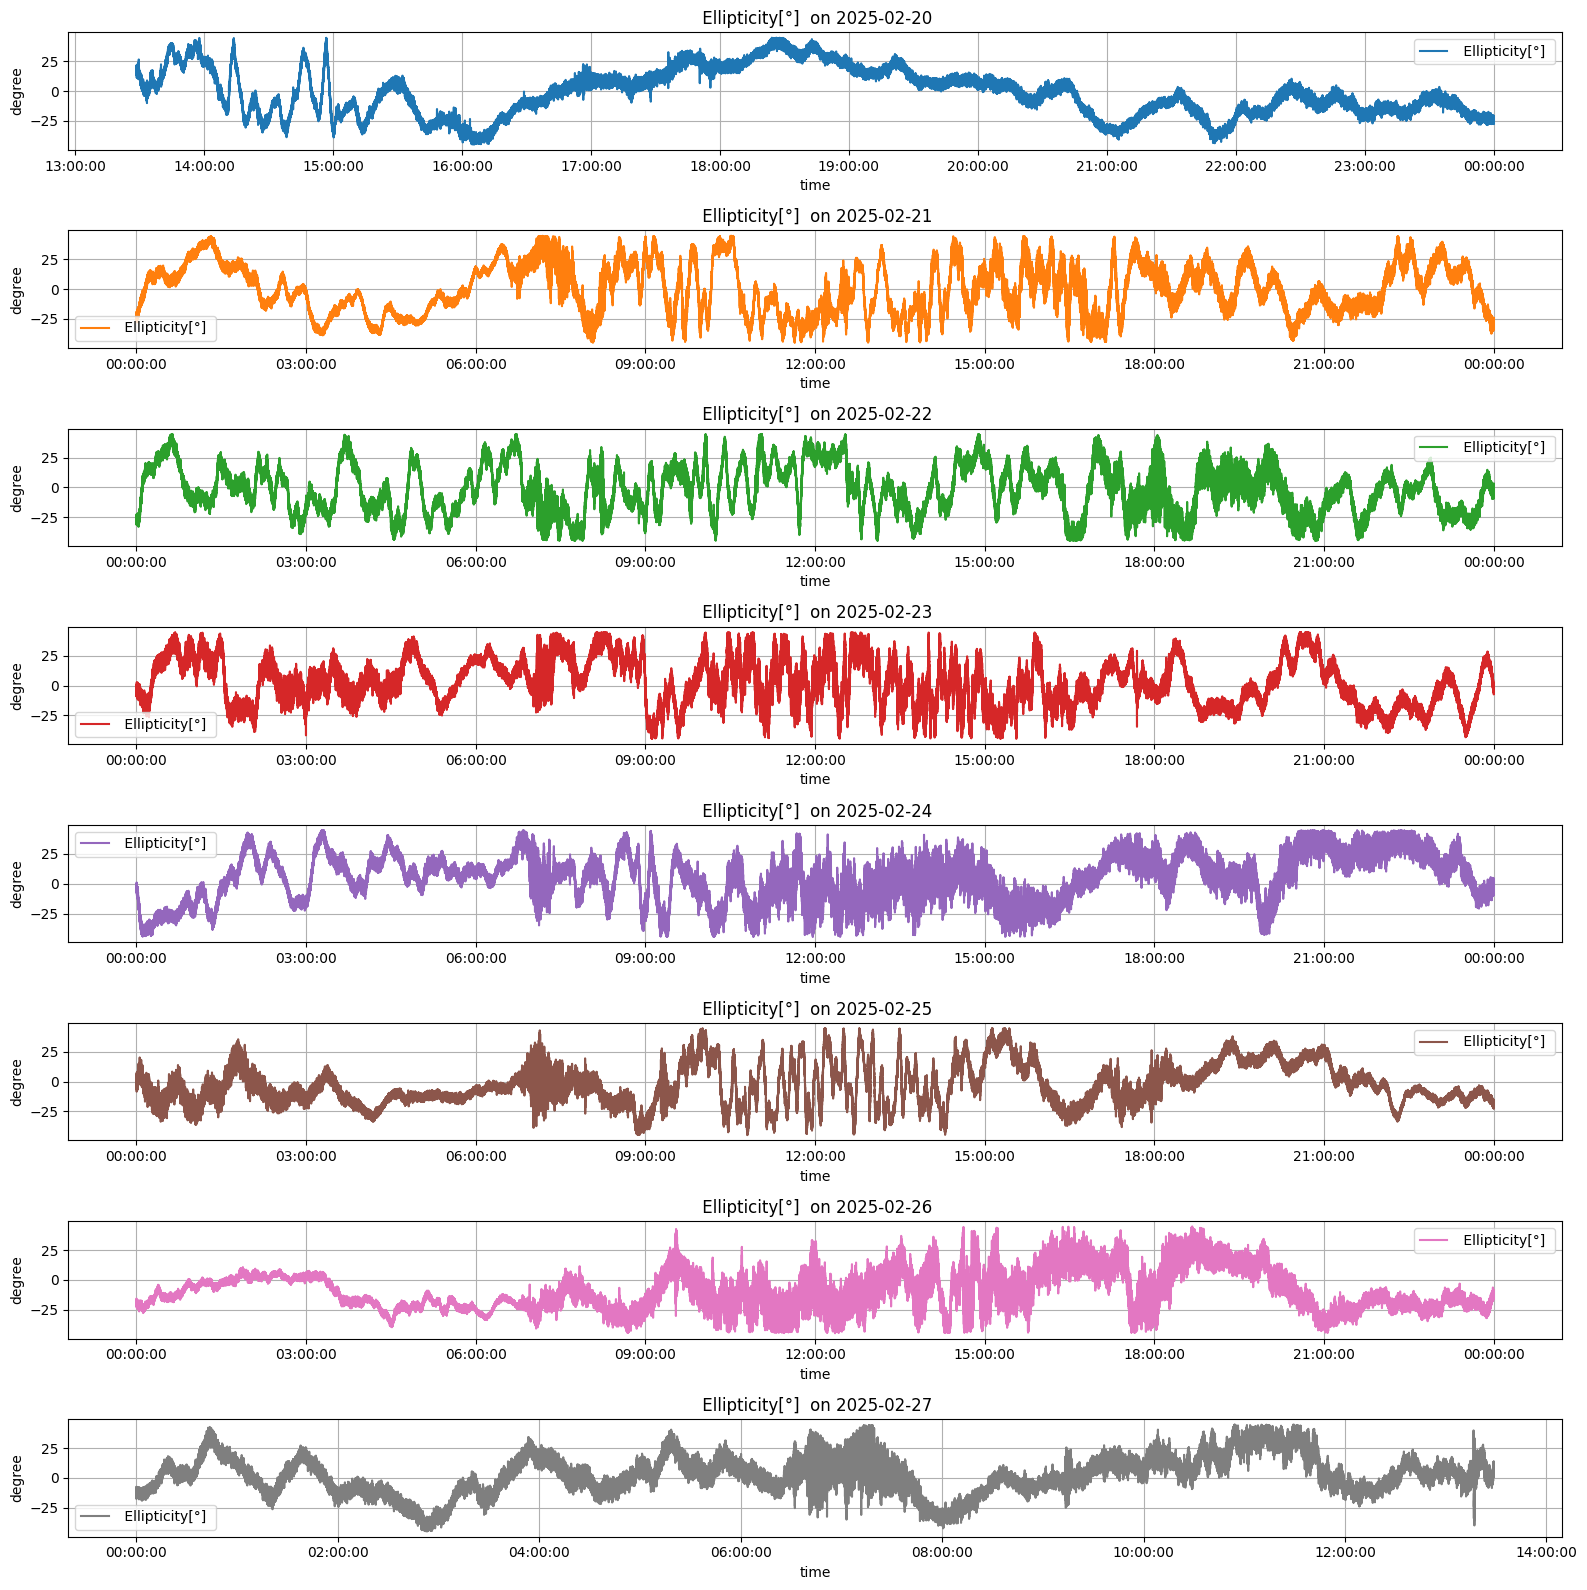

In [21]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]

    ax.plot(df_day.index, df_day, label=columns[10], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[10]} on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

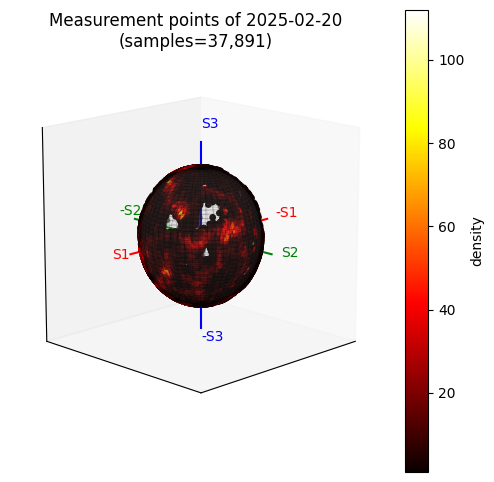

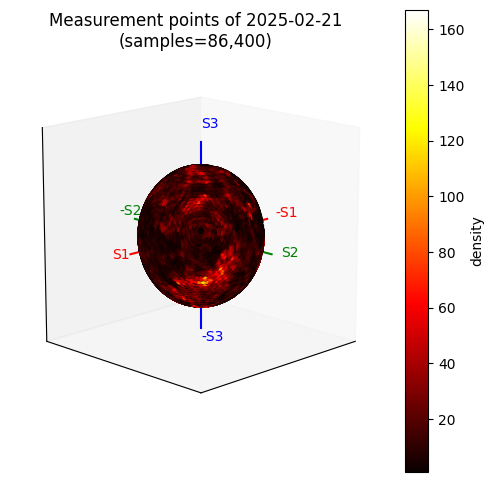

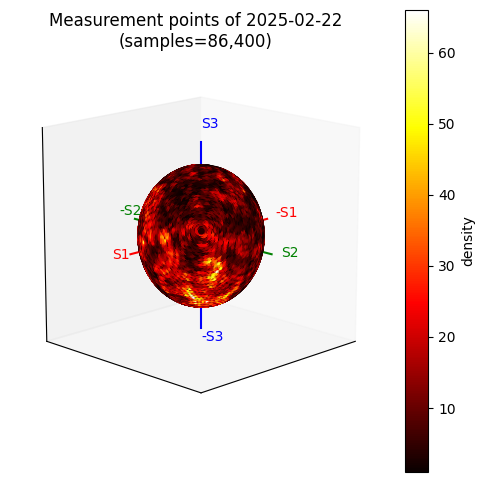

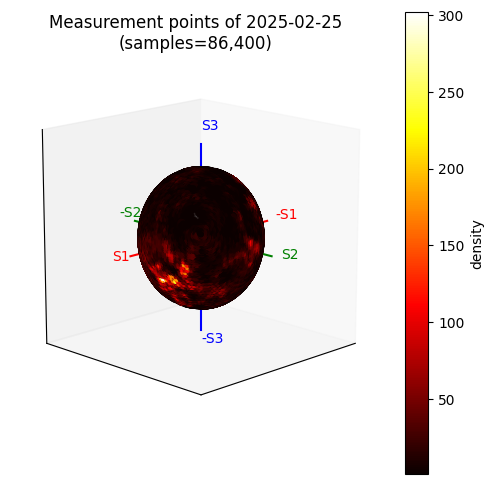

In [22]:
for i in range(len(angle_daily_list)):
    df_day = angle_daily_list[i][1]
    resample = df_day.resample('s').mean().ffill()
    title = f'Measurement points of {angle_daily_list[i][0]}\n(samples={len(resample):,})'

    x,y,z = convert_angel(resample[columns[9]], resample[columns[10]])
    freq = calculate_freq(x, y, z)
    plot_poincare(x, y, z, freq, title=title)

## Normalverteilung

In [23]:
for i in range(len(angle_daily_list)):
    ydata1 = np.array(angle_daily_list[i][1][columns[10]])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    plt.plot(x1, y1, label = angle_daily_list[i][0])
    
plt.title(f'Normal Distribution')
plt.legend(loc = 'best')
plt.xlabel(columns[10])
plt.ylabel('density')
plt.grid()
plt.show()

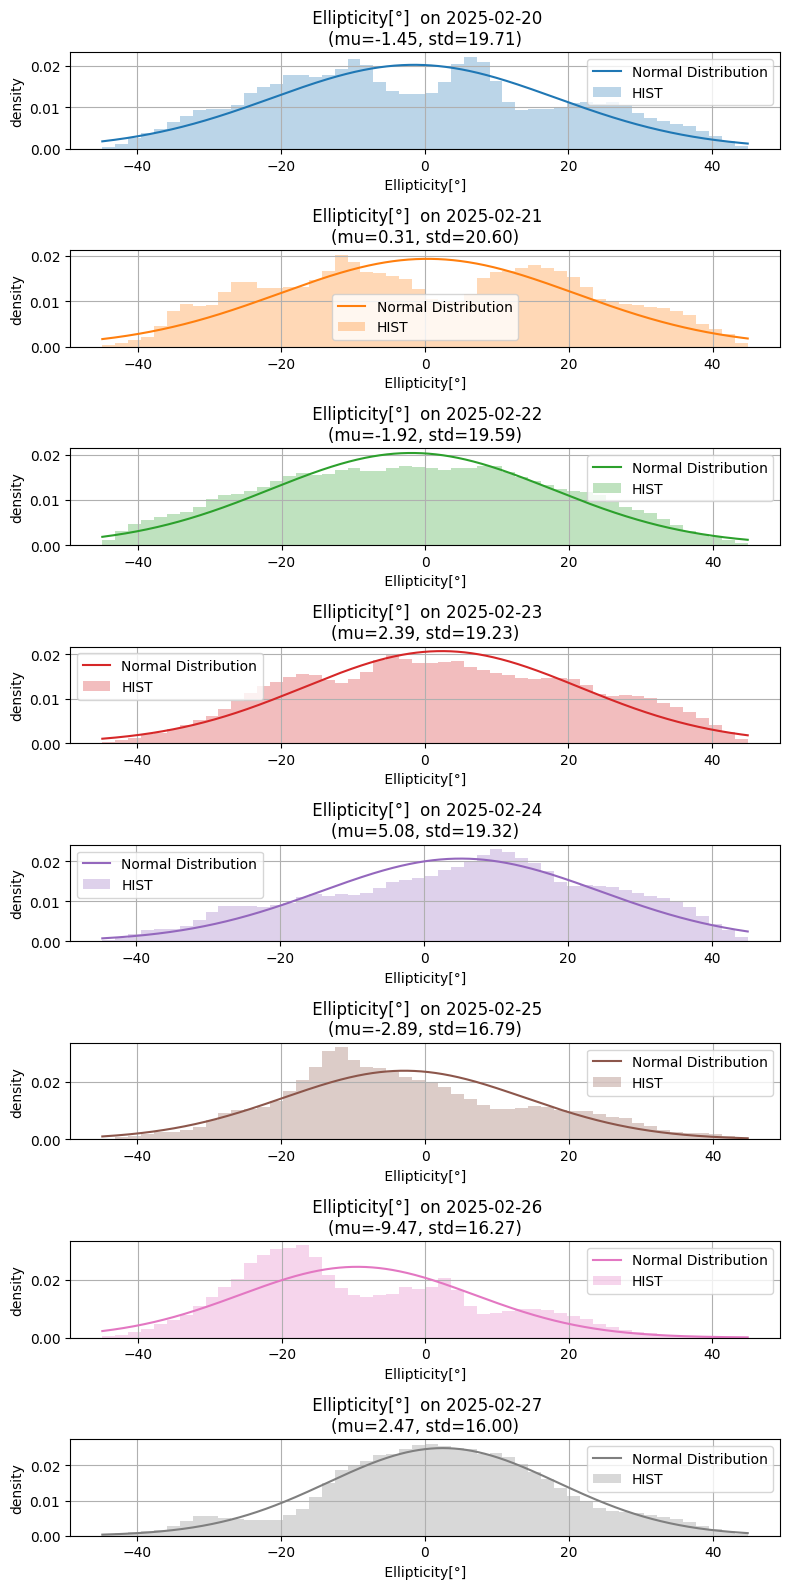

In [24]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    ydata1 = np.array(angle_daily_list[i][1][columns[10]])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[10]} on {angle_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[10])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

## Filterung mittels Tief- und Hochpass

In [25]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    ydata = np.array(df_day[columns[10]])
    lps = lowpass(ydata, 100)
    plt.plot(df_day.index, lps[:-1], label=str(date) , alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter\nof {columns[10]}')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

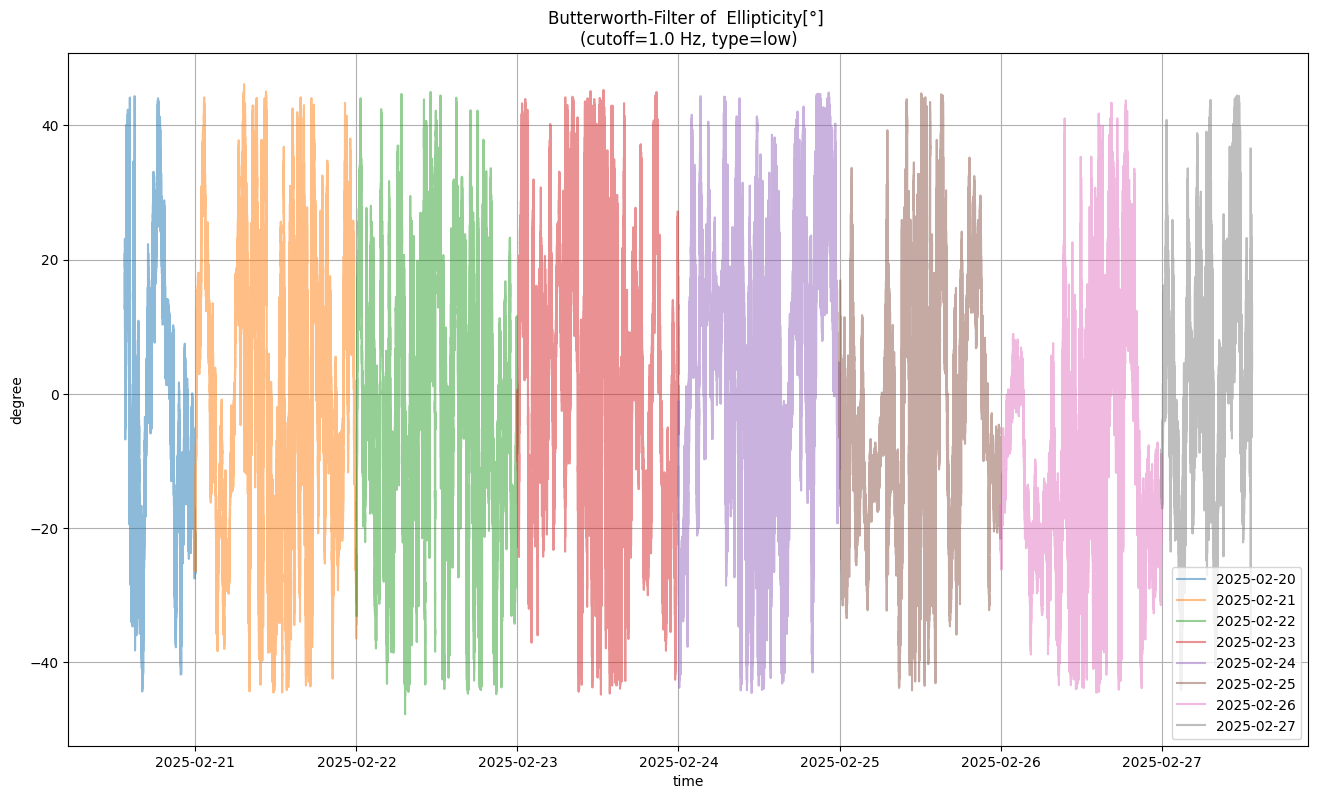

In [26]:
cutoff = 1.0
pass_type = 'low'

plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    ydata = np.array(df_day[columns[10]])
    lps = butter_filter(ydata, cutoff=cutoff, btype=pass_type)
    plt.plot(df_day.index, lps, label=str(date) , alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Butterworth-Filter of {columns[10]}\n(cutoff={cutoff} Hz, type={pass_type})')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

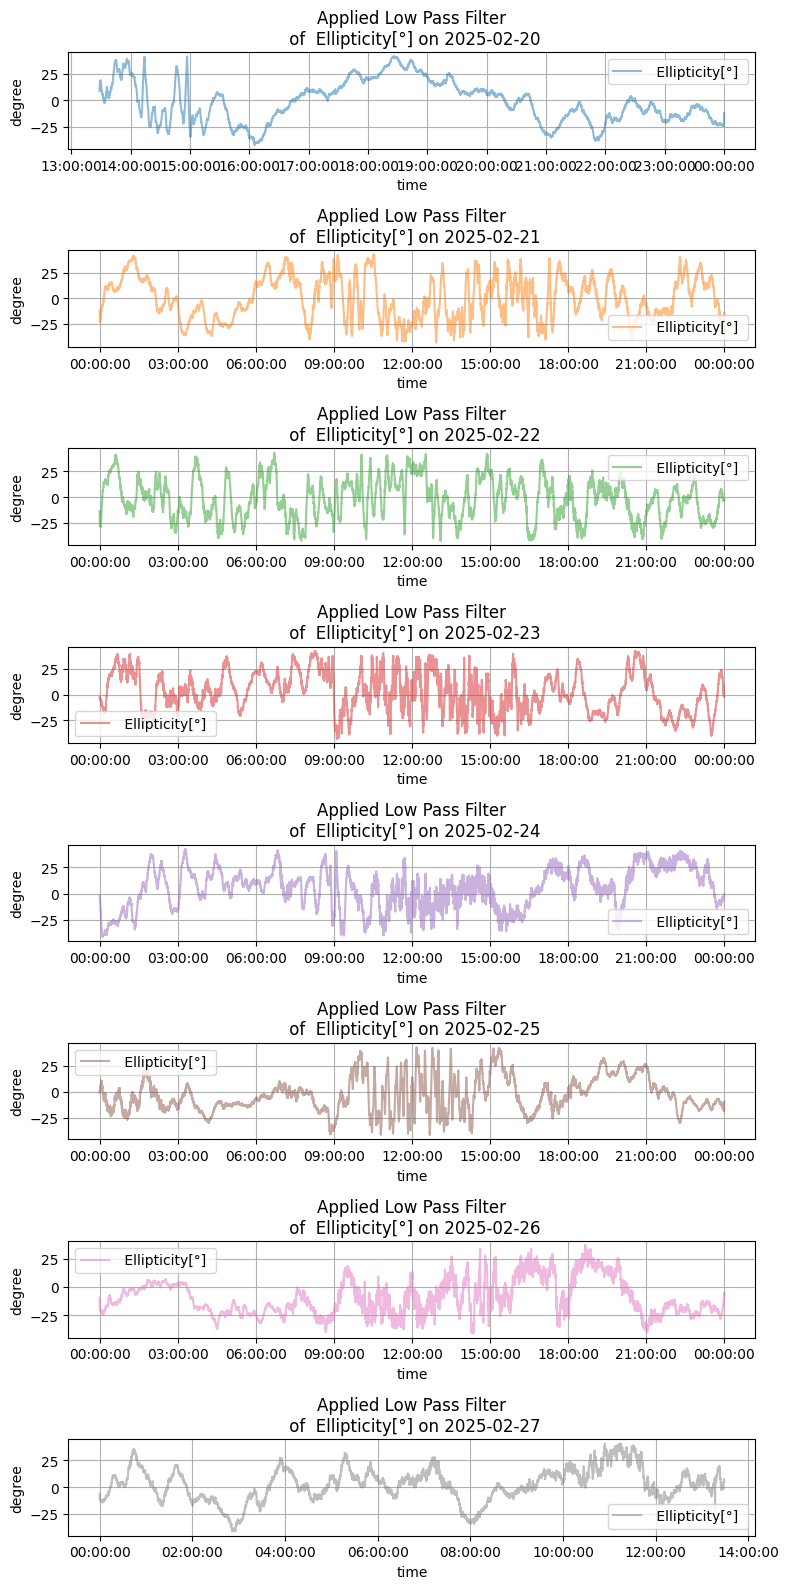

In [27]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]
    ydata = np.array(df_day)
    lps = lowpass(ydata, 100)

    ax.plot(df_day.index, lps[:-1], label=columns[10], color=colors[i], alpha=0.5)
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied Low Pass Filter\n of {columns[10]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

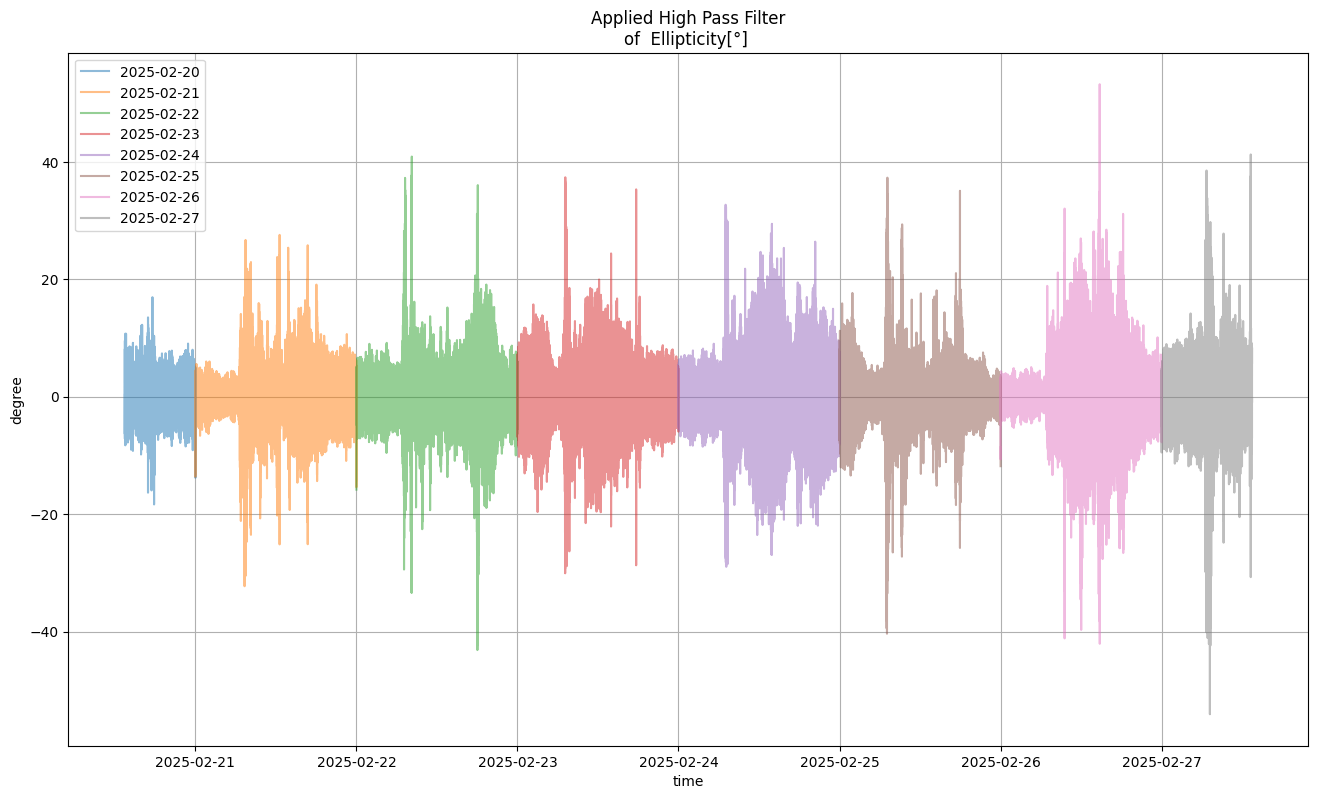

In [28]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    ydata = np.array(df_day[columns[10]])
    hps = highpass(ydata, 100)
    plt.plot(df_day.index, hps, label=str(date) , alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied High Pass Filter\nof {columns[10]}')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

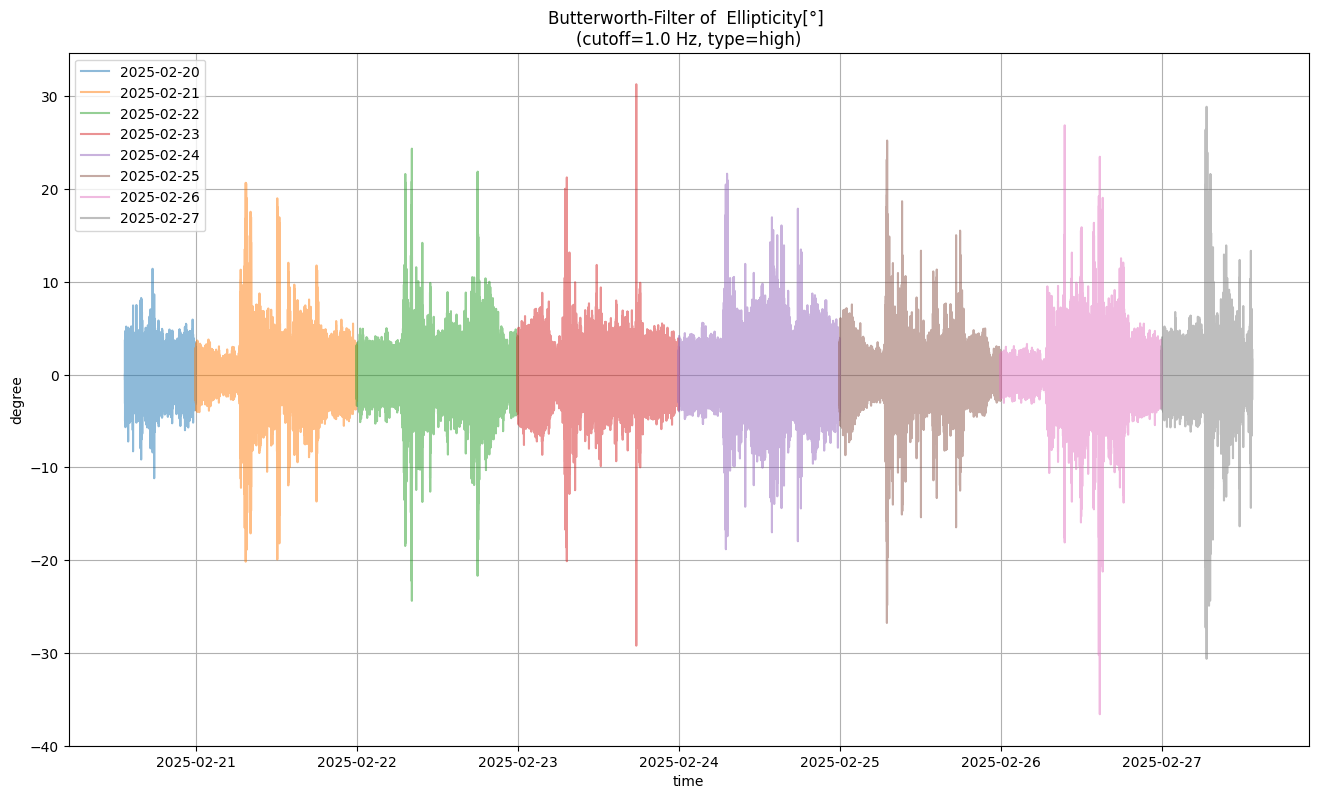

In [29]:
cutoff = 1.0
pass_type = 'high'

plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    ydata = np.array(df_day[columns[10]])
    lps = butter_filter(ydata, cutoff=cutoff, btype=pass_type)
    plt.plot(df_day.index, lps, label=str(date) , alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Butterworth-Filter of {columns[10]}\n(cutoff={cutoff} Hz, type={pass_type})')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

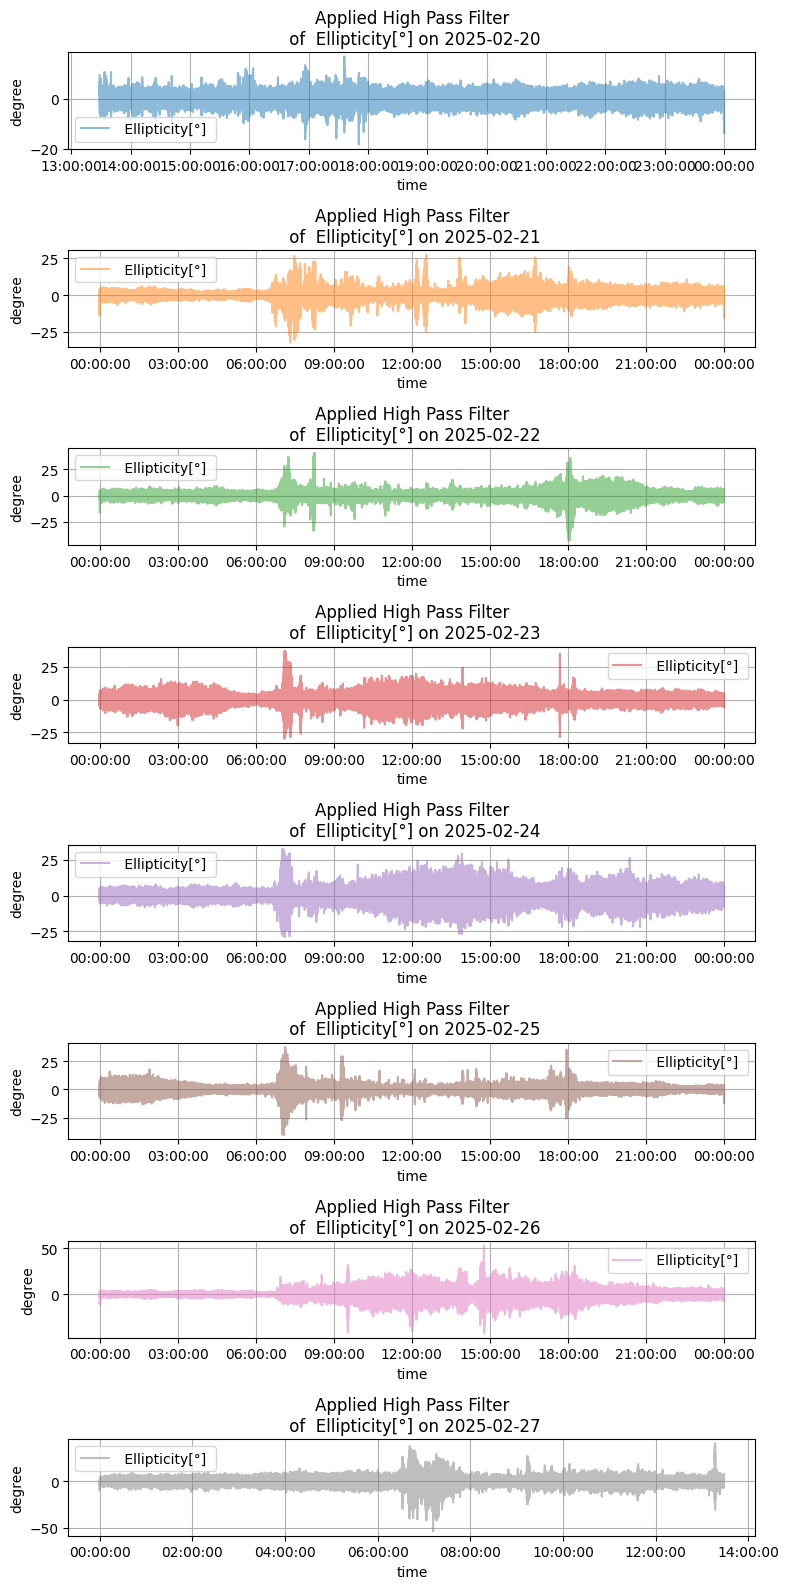

In [30]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]
    ydata = np.array(df_day)
    hps = highpass(ydata, 100)

    ax.plot(df_day.index, hps, label=columns[10], color=colors[i], alpha=0.5)
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'Applied High Pass Filter\n of {columns[10]}on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

## Analyse potenzieller Zusammenhänge
### Originaldaten und Wetterparameter

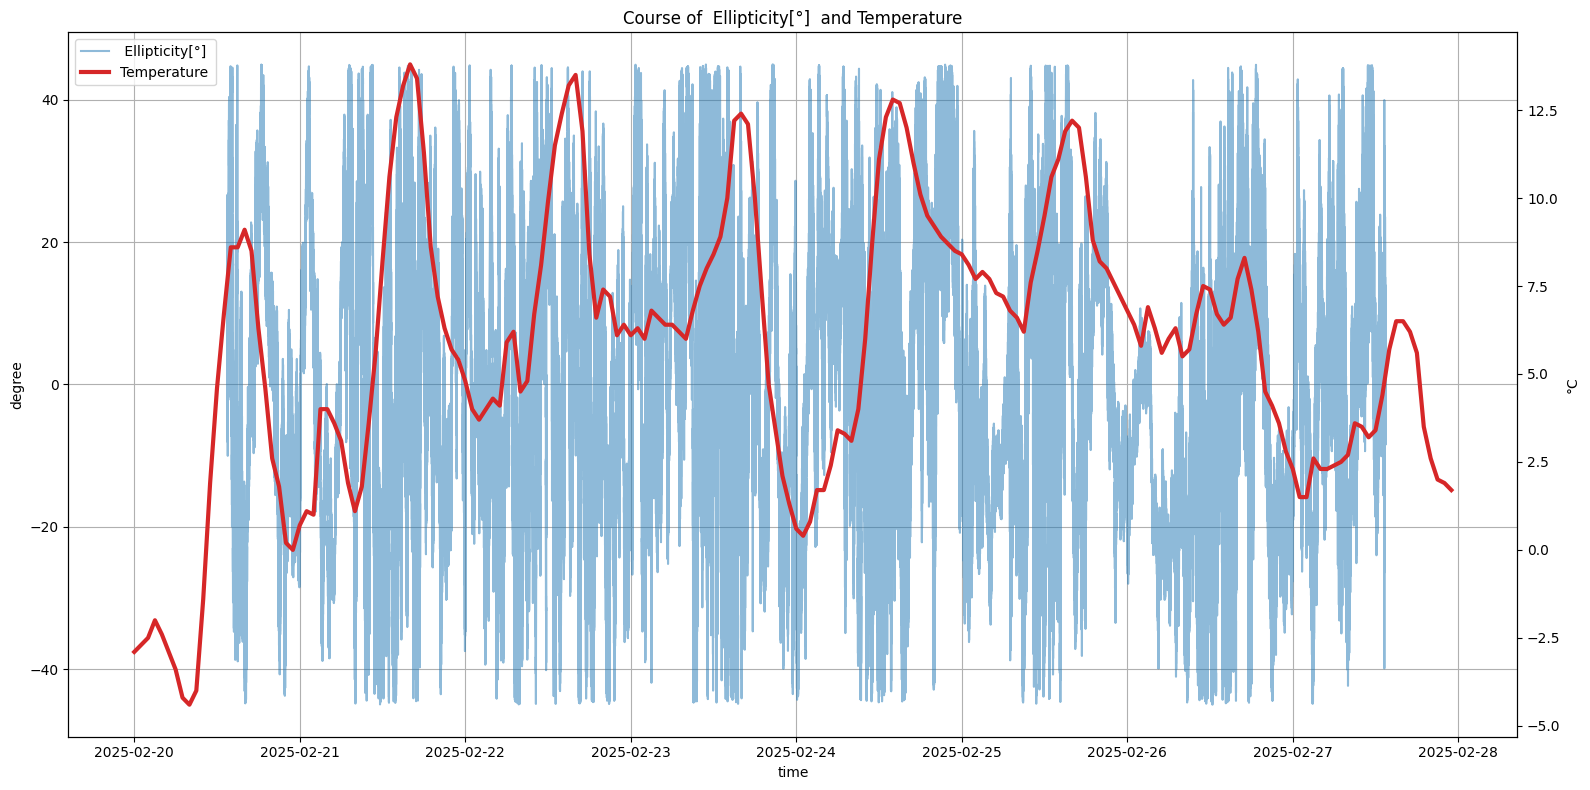

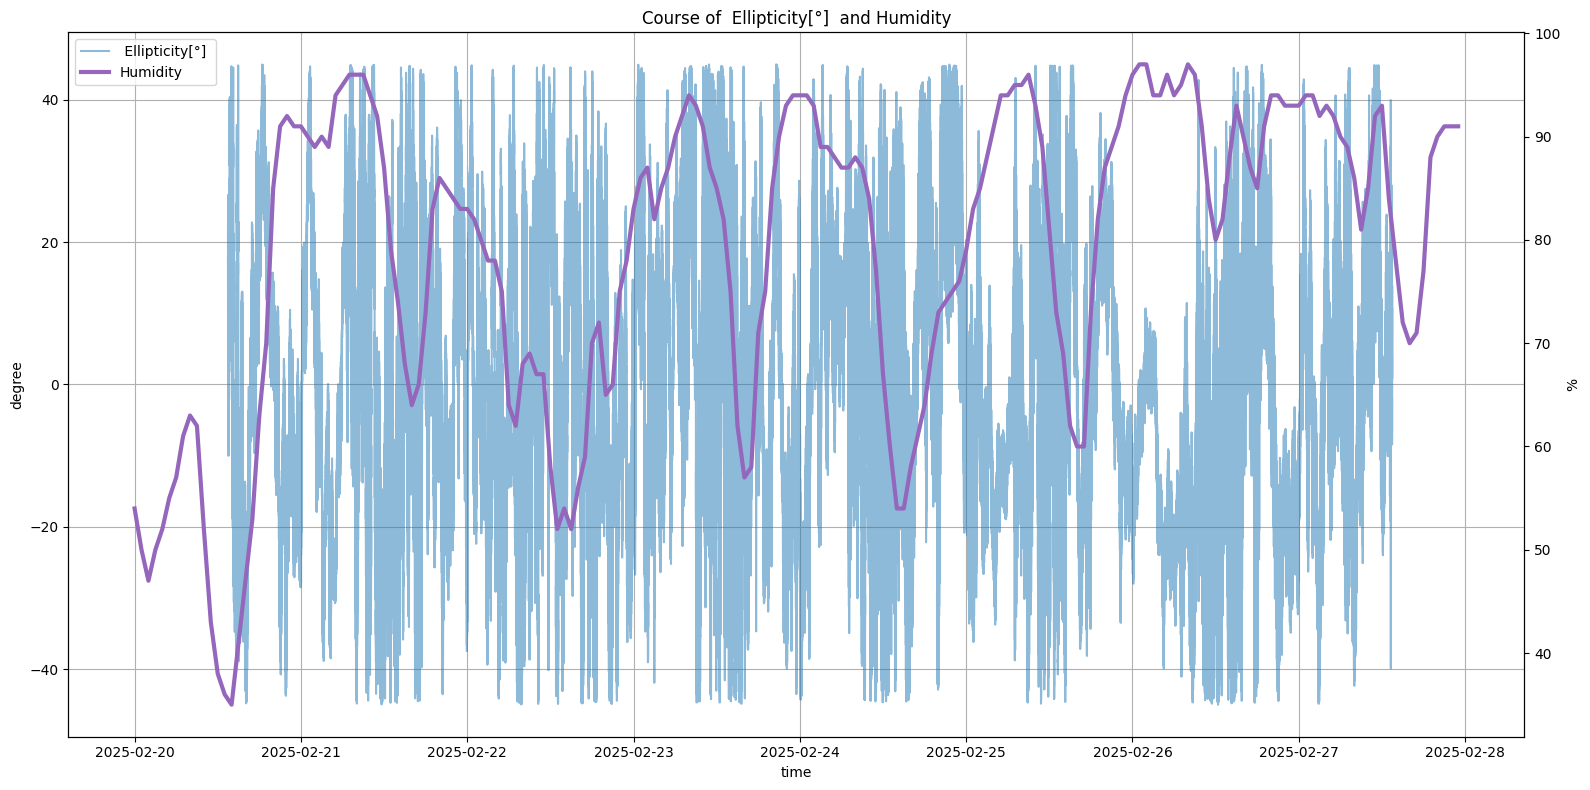

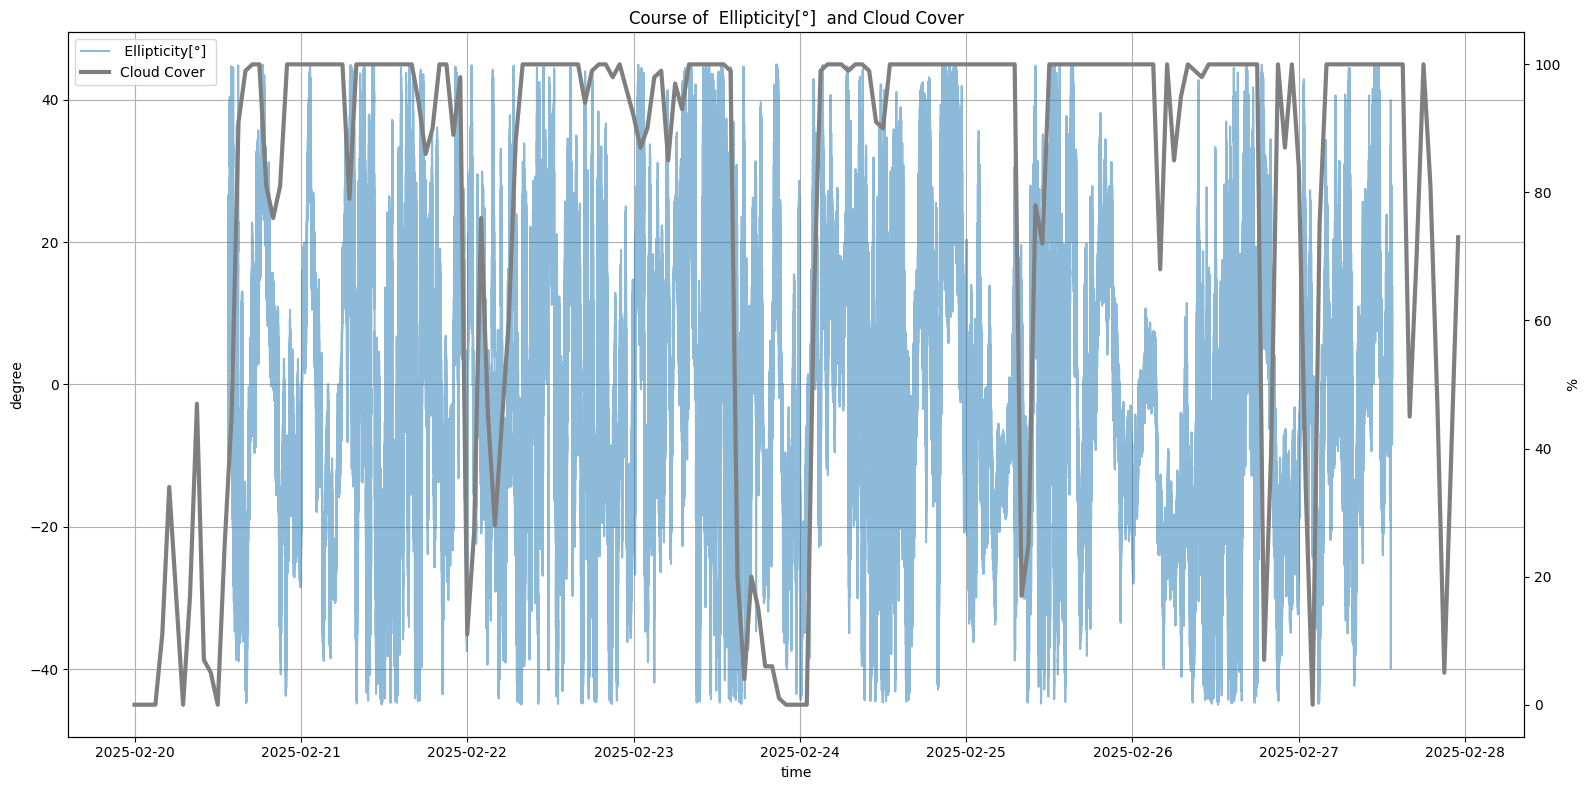

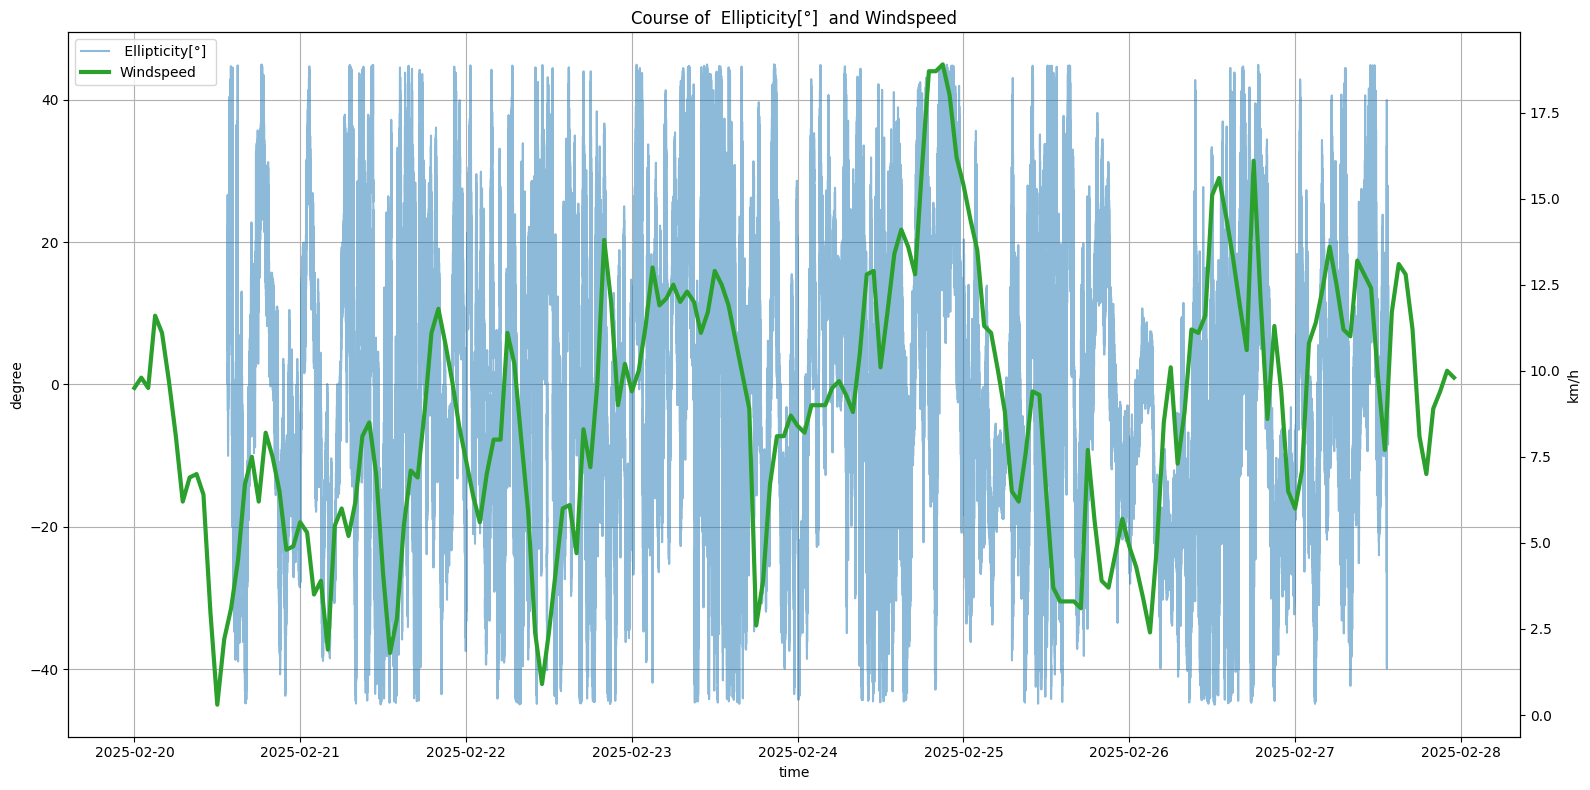

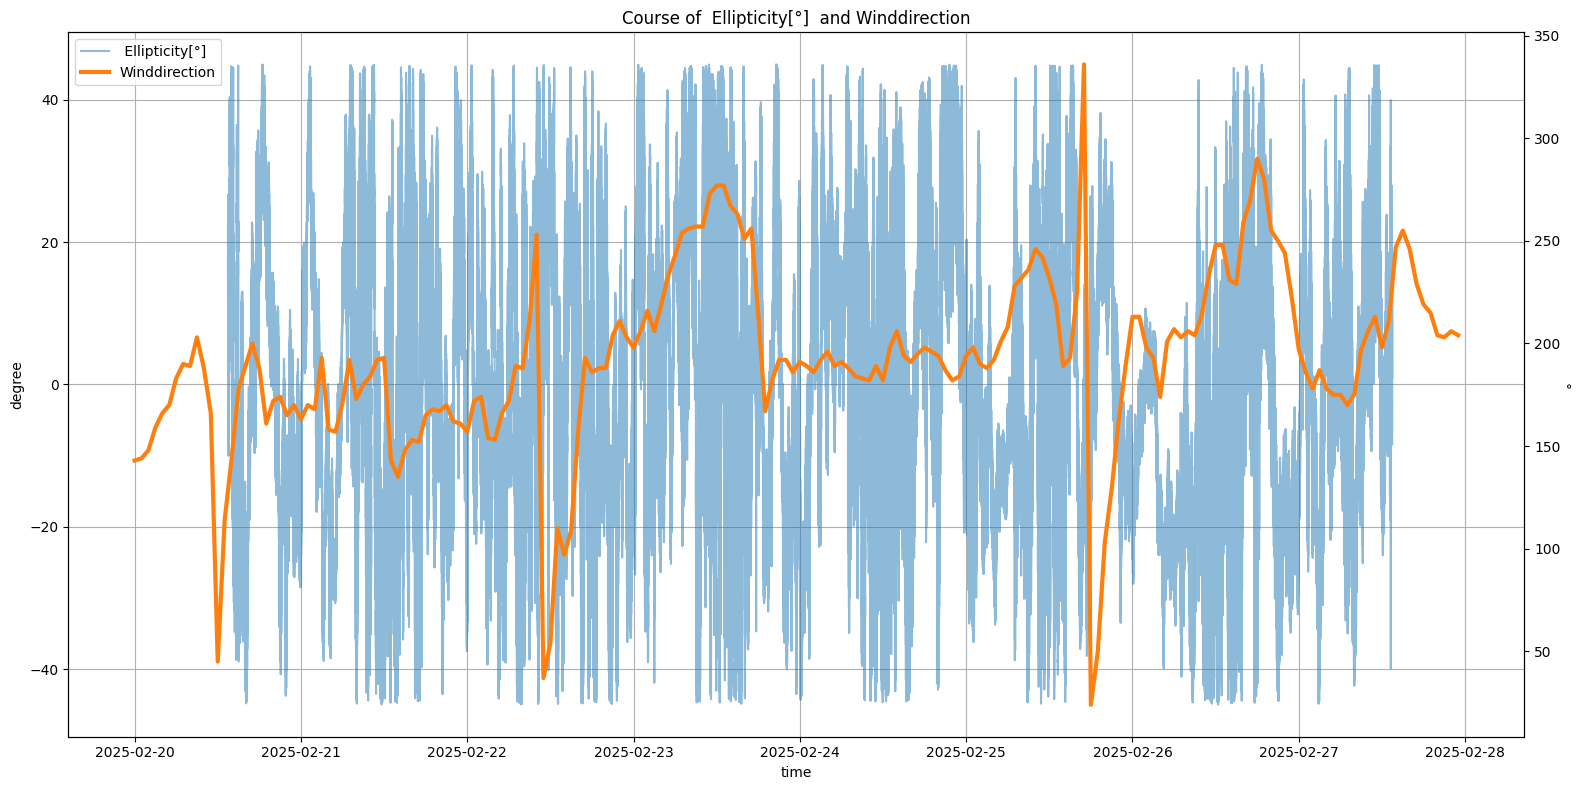

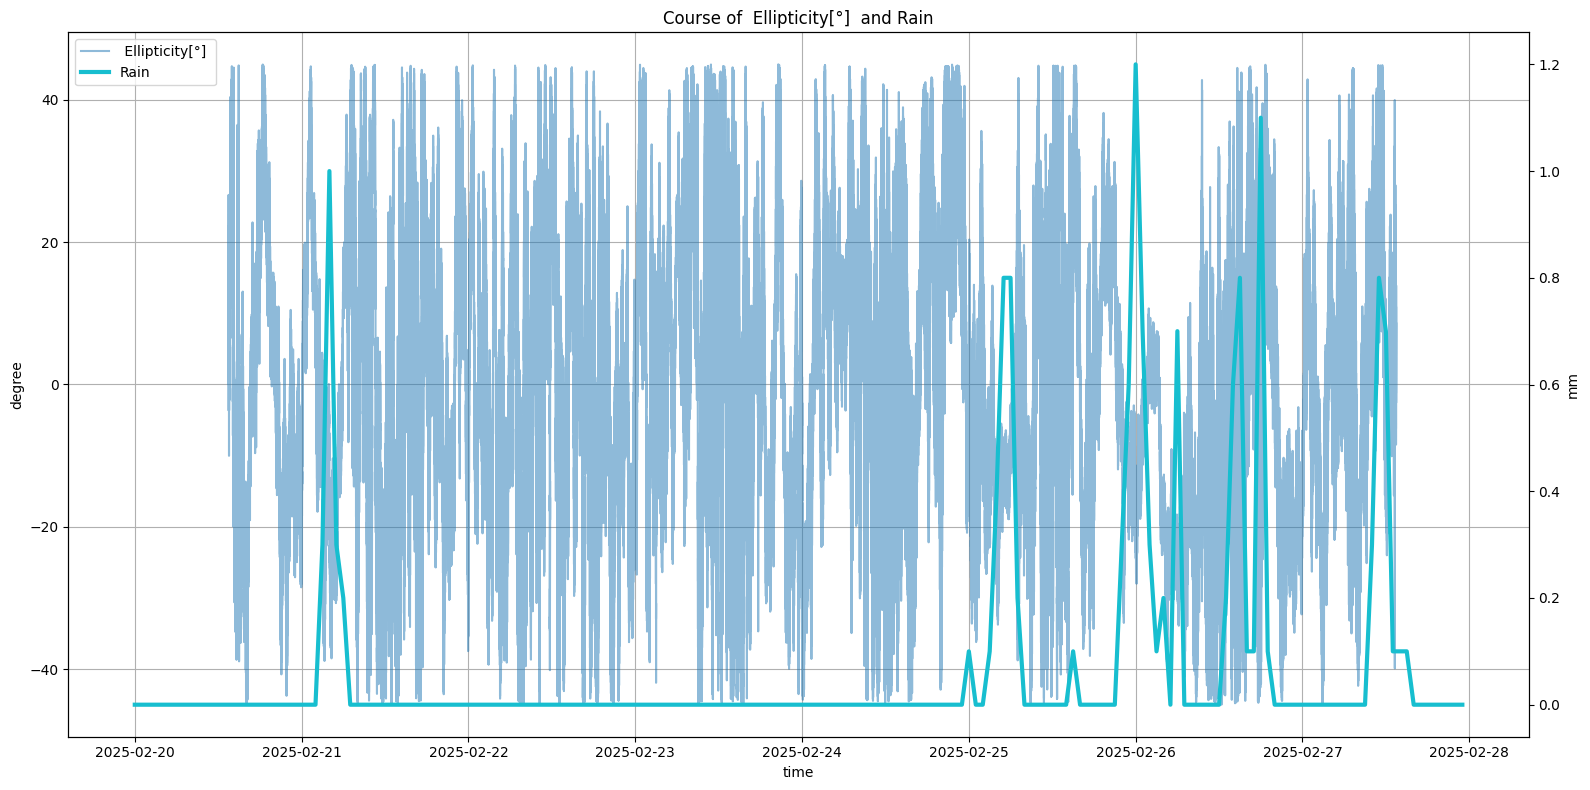

In [31]:
for current in range(len(w_data)):
    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.plot(angle[columns[10]], label=columns[10], alpha= 0.5)
    ax1.set_xlabel('time')
    ax1.set_ylabel('degree')
    h1, l1 = ax1.get_legend_handles_labels()

    ax2 = ax1.twinx()

    ax2.plot(weather.index, weather[w_data[current]["header"]], label=w_data[current]["label"], color = w_data[current]["color"], linewidth=3)
    ax2.set_ylabel(w_data[current]["unit"])
    h2, l2 = ax2.get_legend_handles_labels()

    ax1.grid()
    ax1.legend(h1+h2, l1+l2, loc="best")
    ax1.set_title(f'Course of {columns[10]} and {w_data[current]["label"]}')

    plt.tight_layout()
    plt.show()

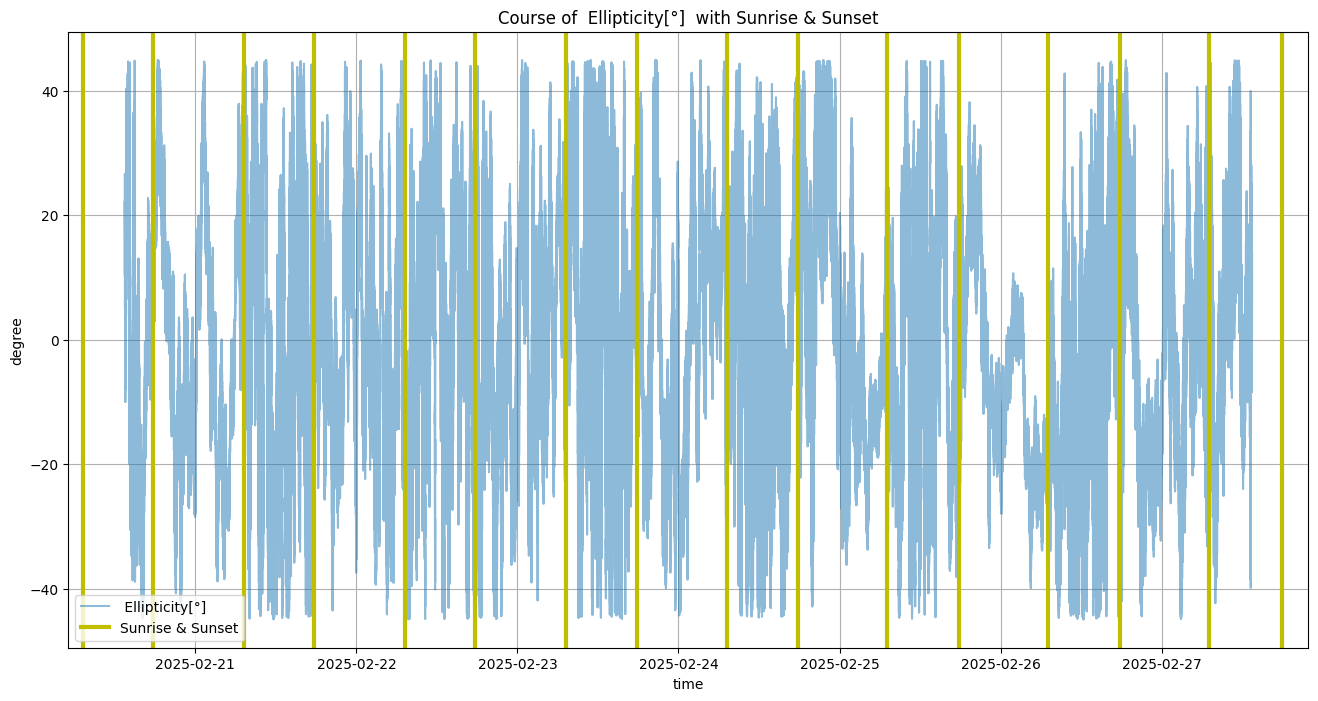

In [32]:
# Sunlight (day-night context)

plt.figure(figsize = (16,8))
plt.plot(angle.index, angle[columns[10]], label=columns[10], alpha= 0.5)
for i in range(len(sunrise)):
    plt.axvline(x = sunrise[i], color = 'y', linewidth=3)
    if i == 0: plt.axvline(x = sunset[i], color = 'y',label = 'Sunrise & Sunset', linewidth=3)
    else: plt.axvline(x = sunset[i], color = 'y', linewidth=3)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[10]} with Sunrise & Sunset')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

### Tiefpass-gefilterte Daten und Wetterparameter

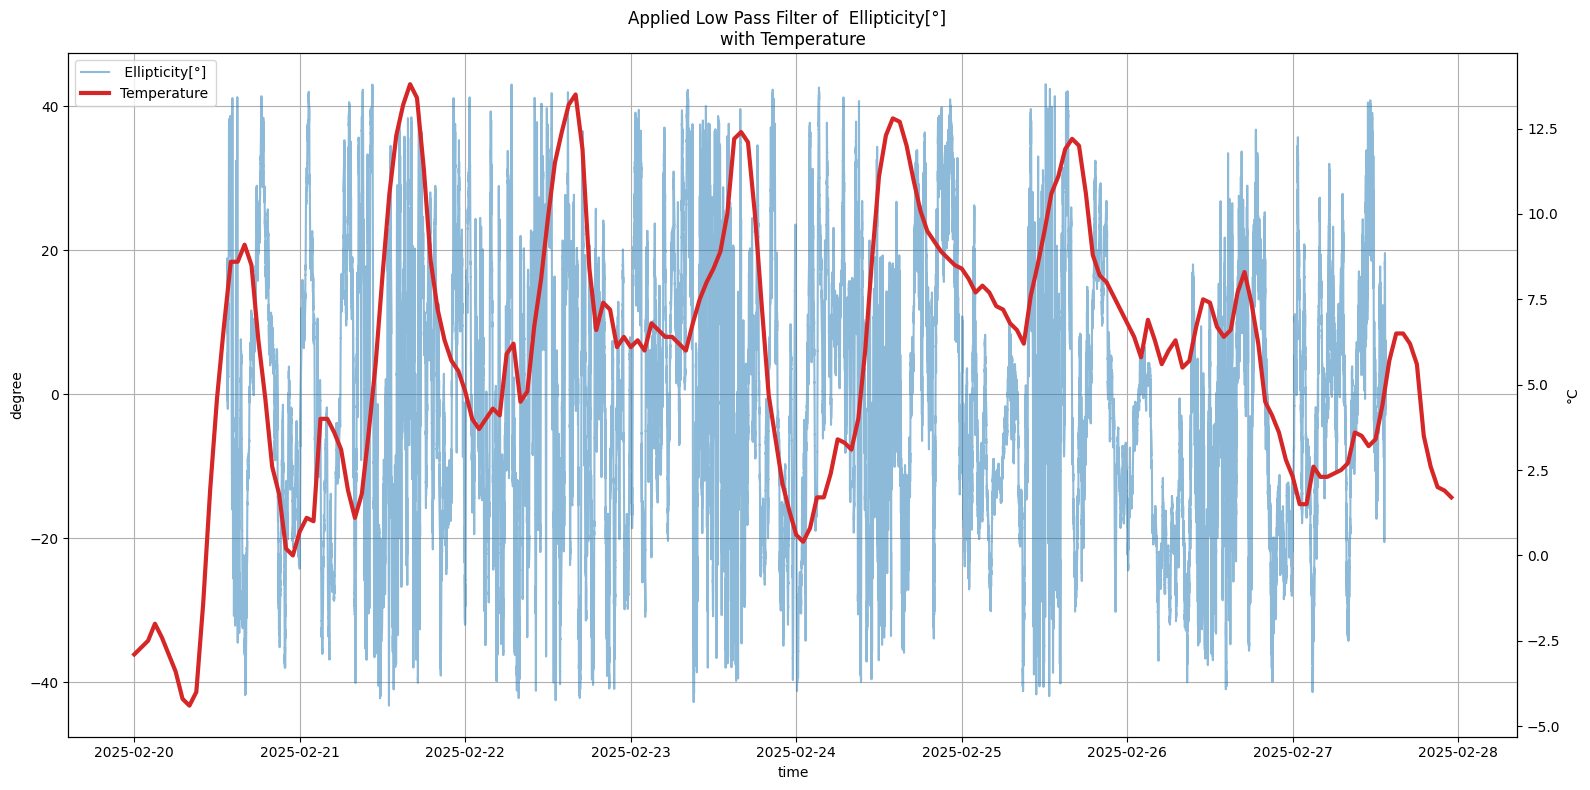

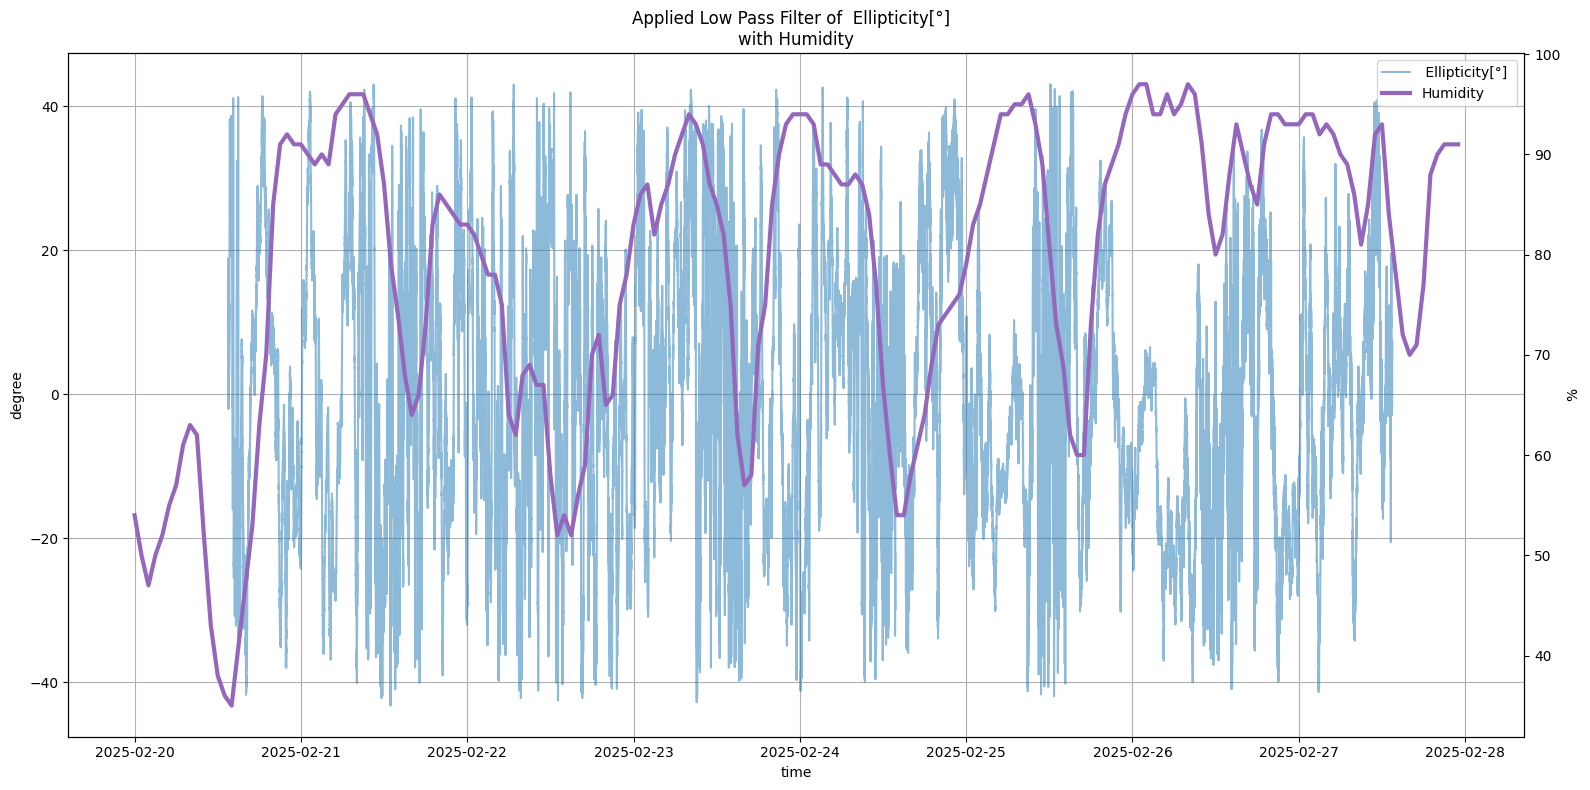

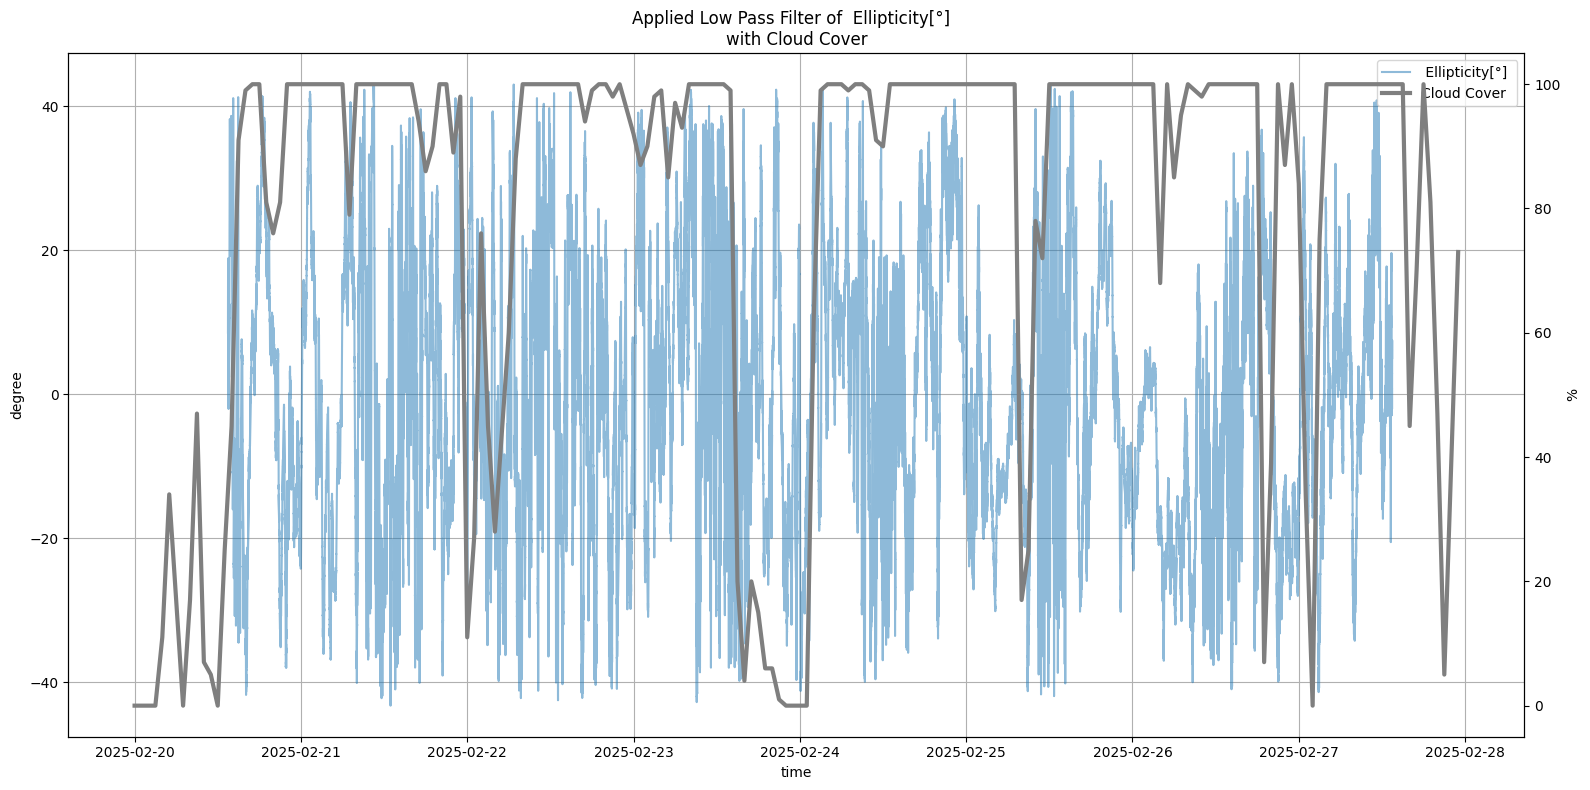

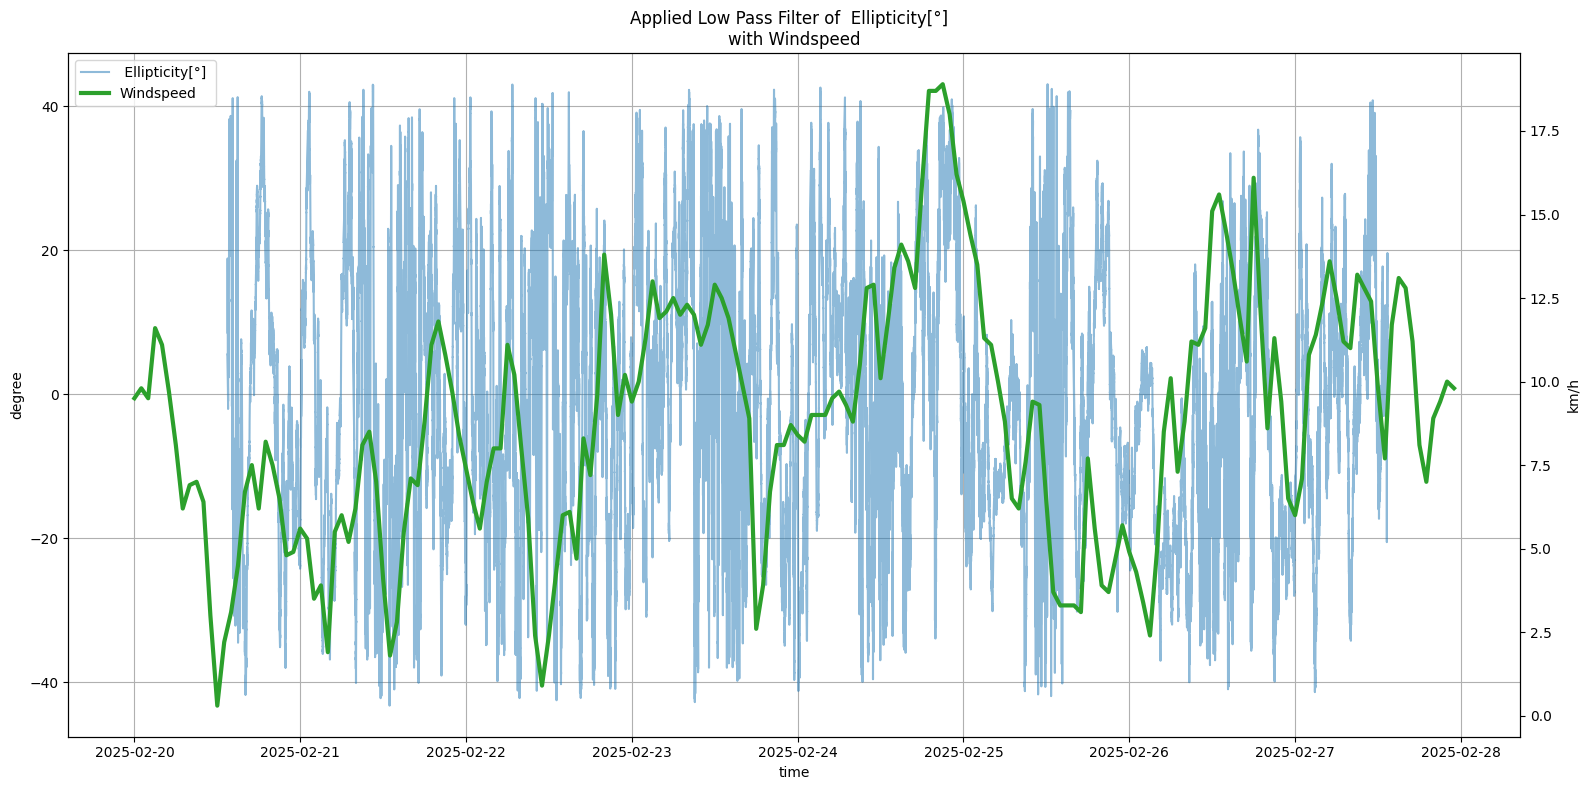

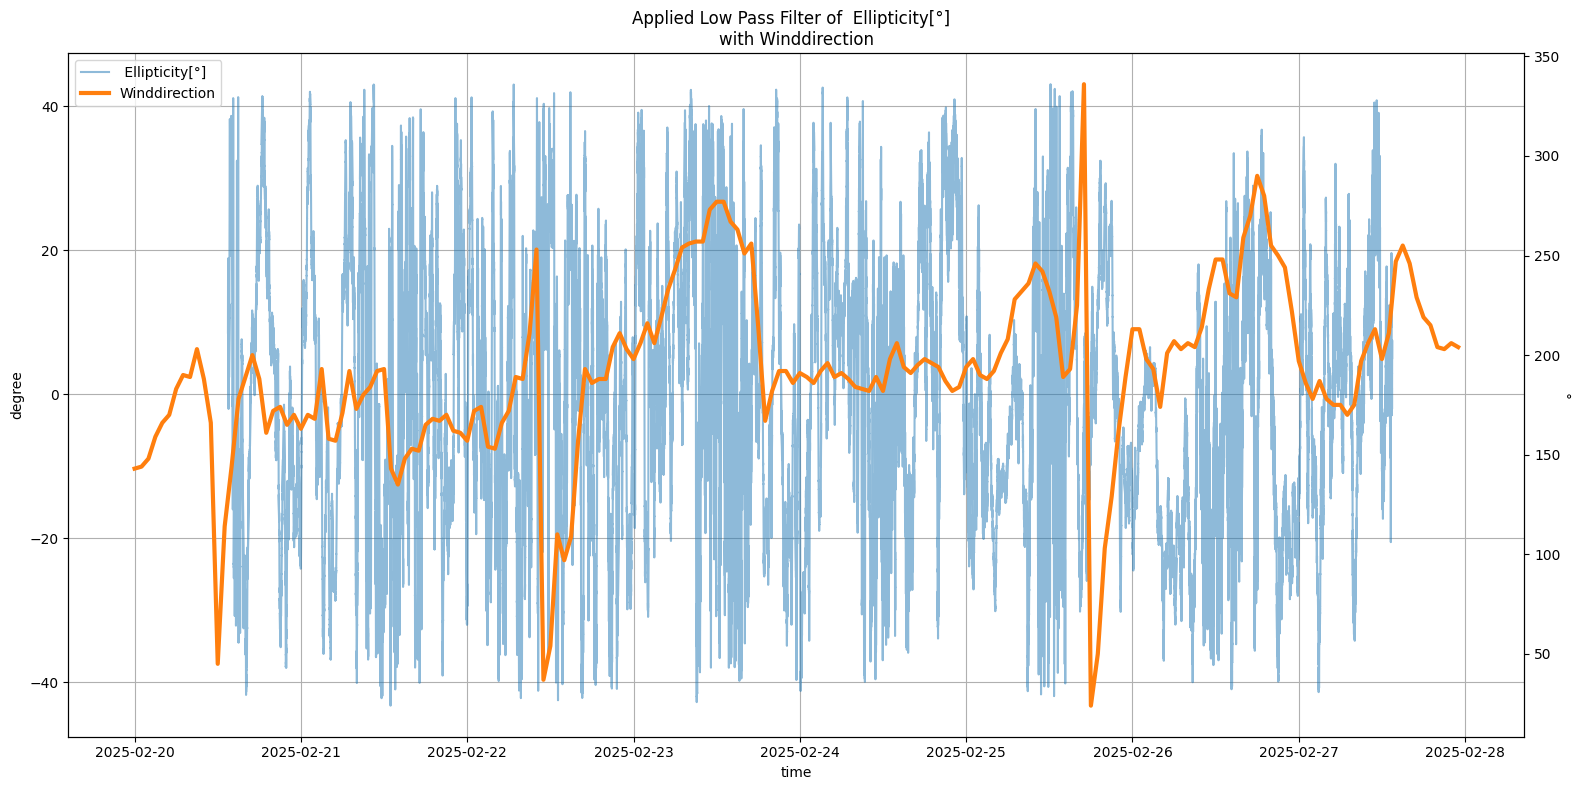

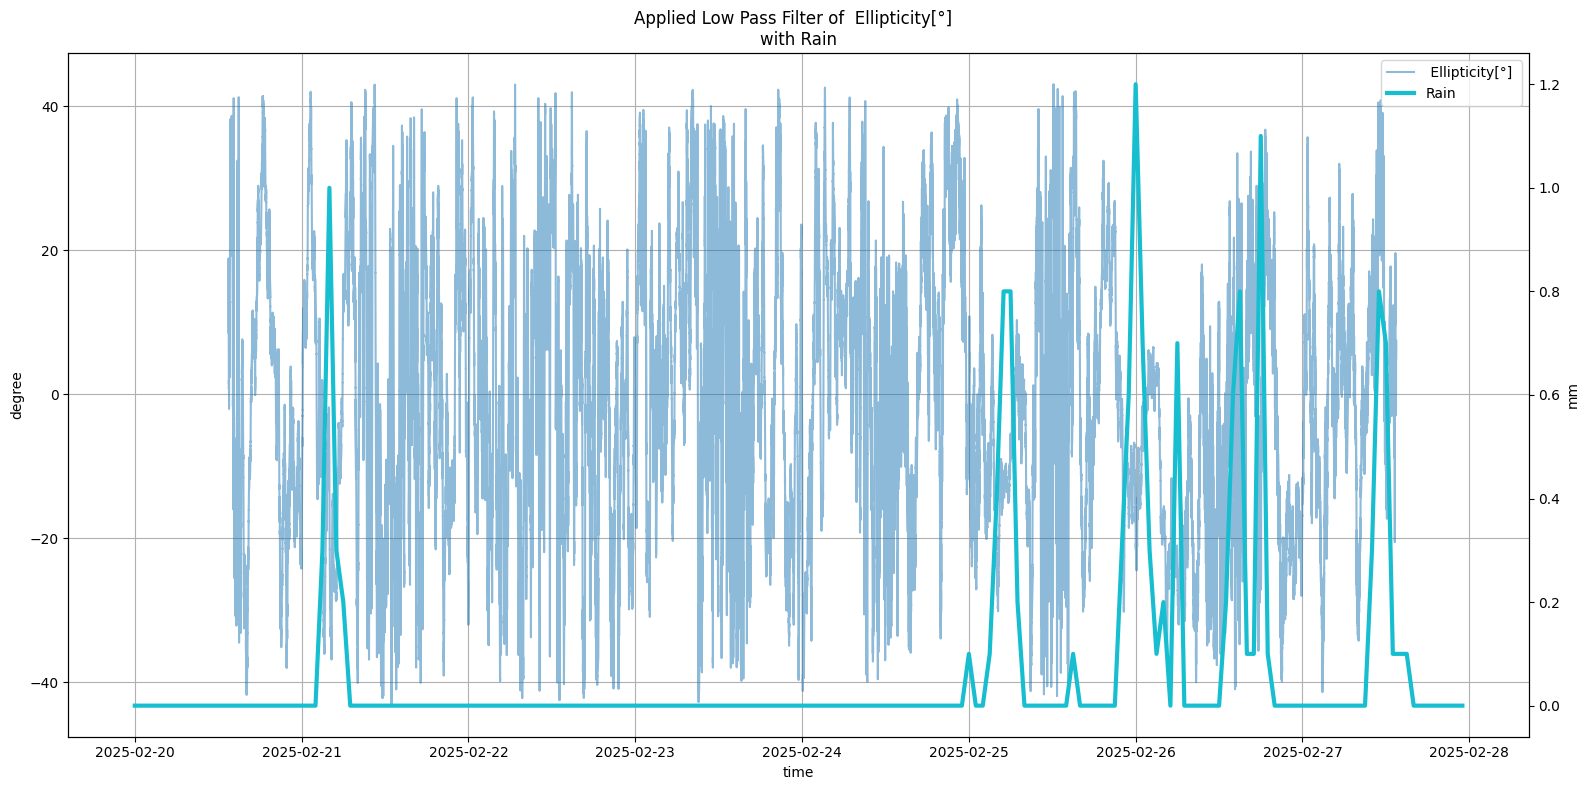

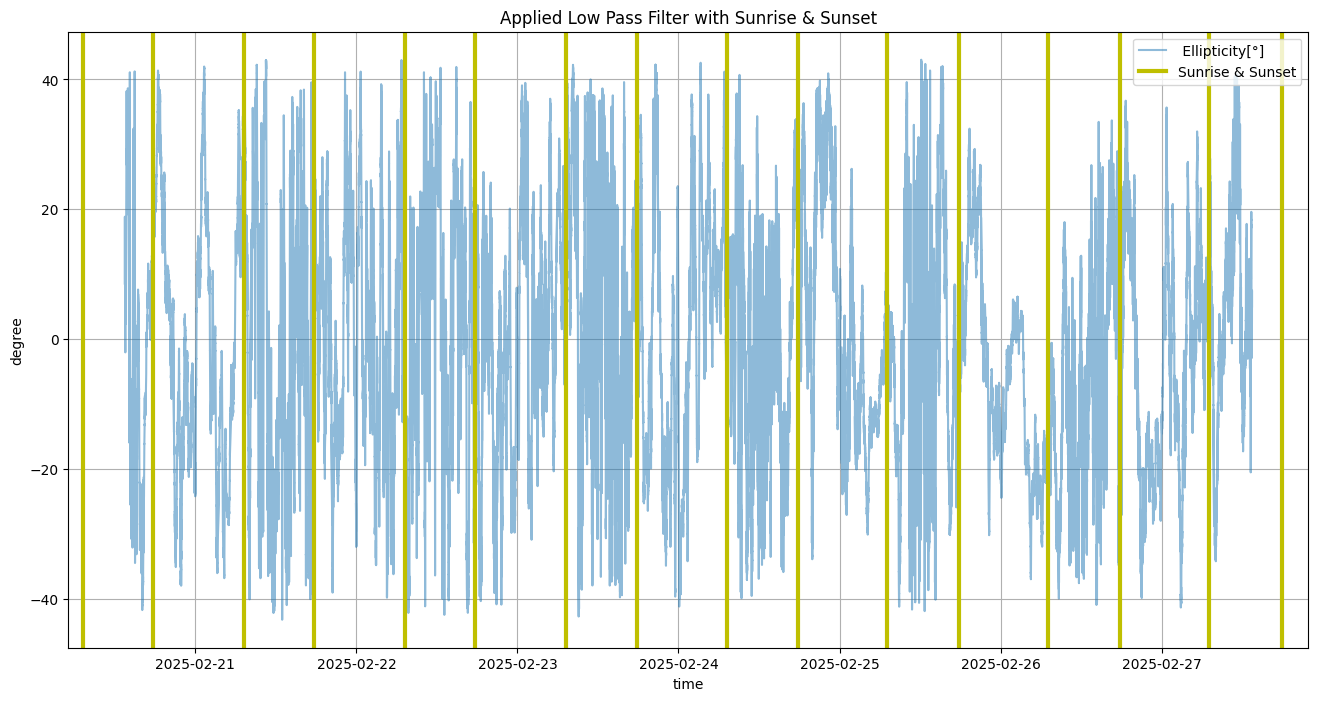

In [33]:
for current in range(len(w_data)):
    fig, ax1 = plt.subplots(figsize=(16, 8))

    ydata = np.array(angle[columns[10]])
    lps = lowpass(ydata, 100)

    ax1.plot(angle.index, lps[:-1], label=columns[10], color= "tab:blue", alpha= 0.5)

    ax1.set_xlabel('time')
    ax1.set_ylabel('degree')
    h1, l1 = ax1.get_legend_handles_labels()

    ax2 = ax1.twinx()

    ax2.plot(weather.index, weather[w_data[current]["header"]], label=w_data[current]["label"], color = w_data[current]["color"], linewidth=3)
    ax2.set_ylabel(w_data[current]["unit"])
    h2, l2 = ax2.get_legend_handles_labels()

    ax1.grid()
    ax1.legend(h1+h2, l1+l2, loc="best")
    ax1.set_title(f'Applied Low Pass Filter of {columns[10]} \nwith {w_data[current]["label"]}')

    plt.tight_layout()
    plt.show()


# Sunlight (day-night context)

plt.figure(figsize = (16,8))

ydata = np.array(angle[columns[10]])
lps = lowpass(ydata, 100)

plt.plot(angle.index, lps[:-1], label=columns[10], color= "tab:blue", alpha= 0.5)
for i in range(len(sunrise)):
    plt.axvline(x = sunrise[i], color = 'y', linewidth=3)
    if i == 0: plt.axvline(x = sunset[i], color = 'y',label = 'Sunrise & Sunset', linewidth=3)
    else: plt.axvline(x = sunset[i], color = 'y', linewidth=3)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter with Sunrise & Sunset')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

### Hochpass-gefilterte Daten und Wetterparameter

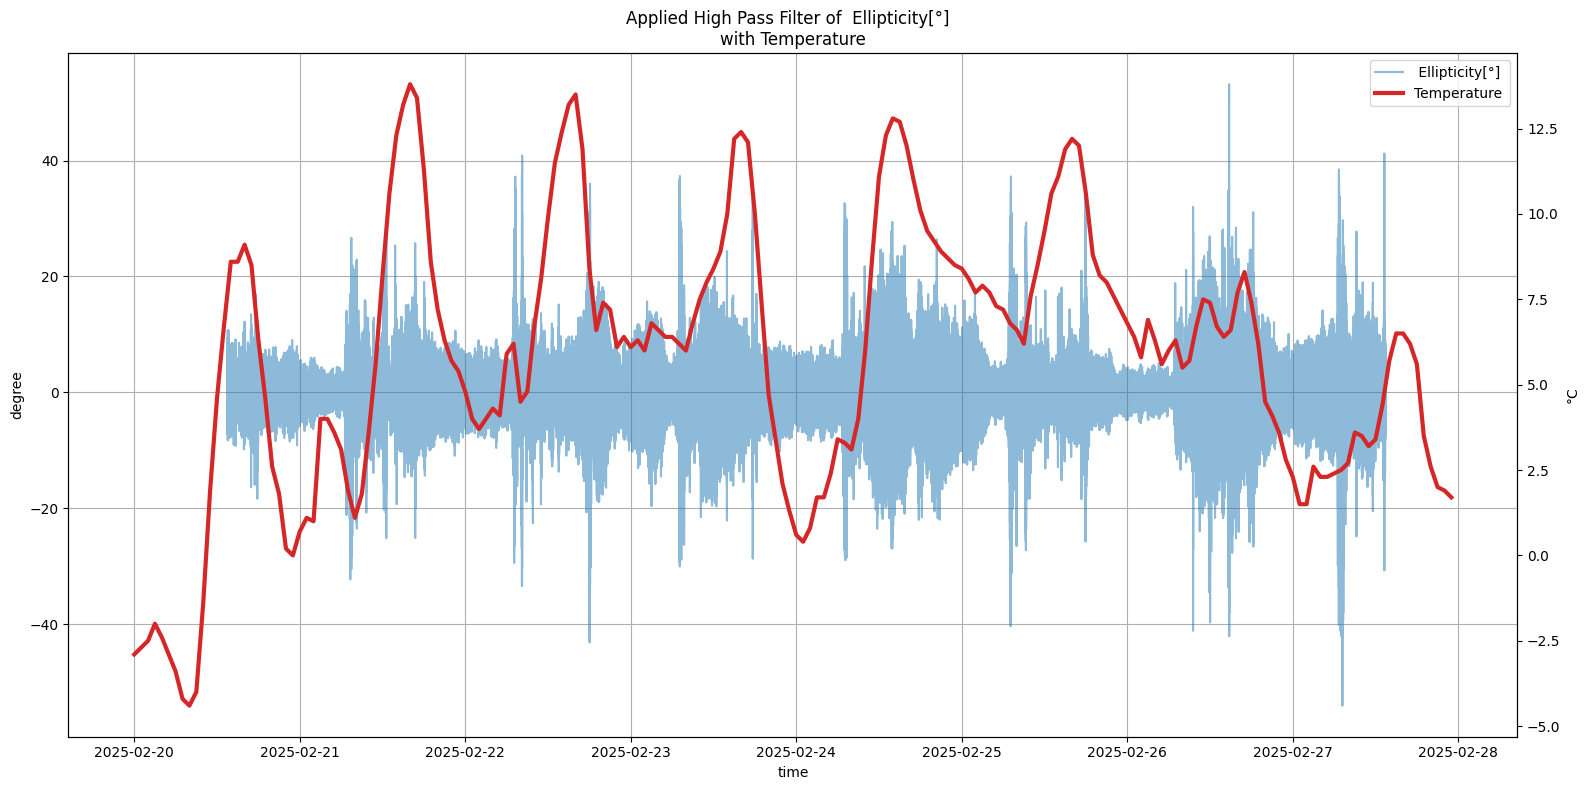

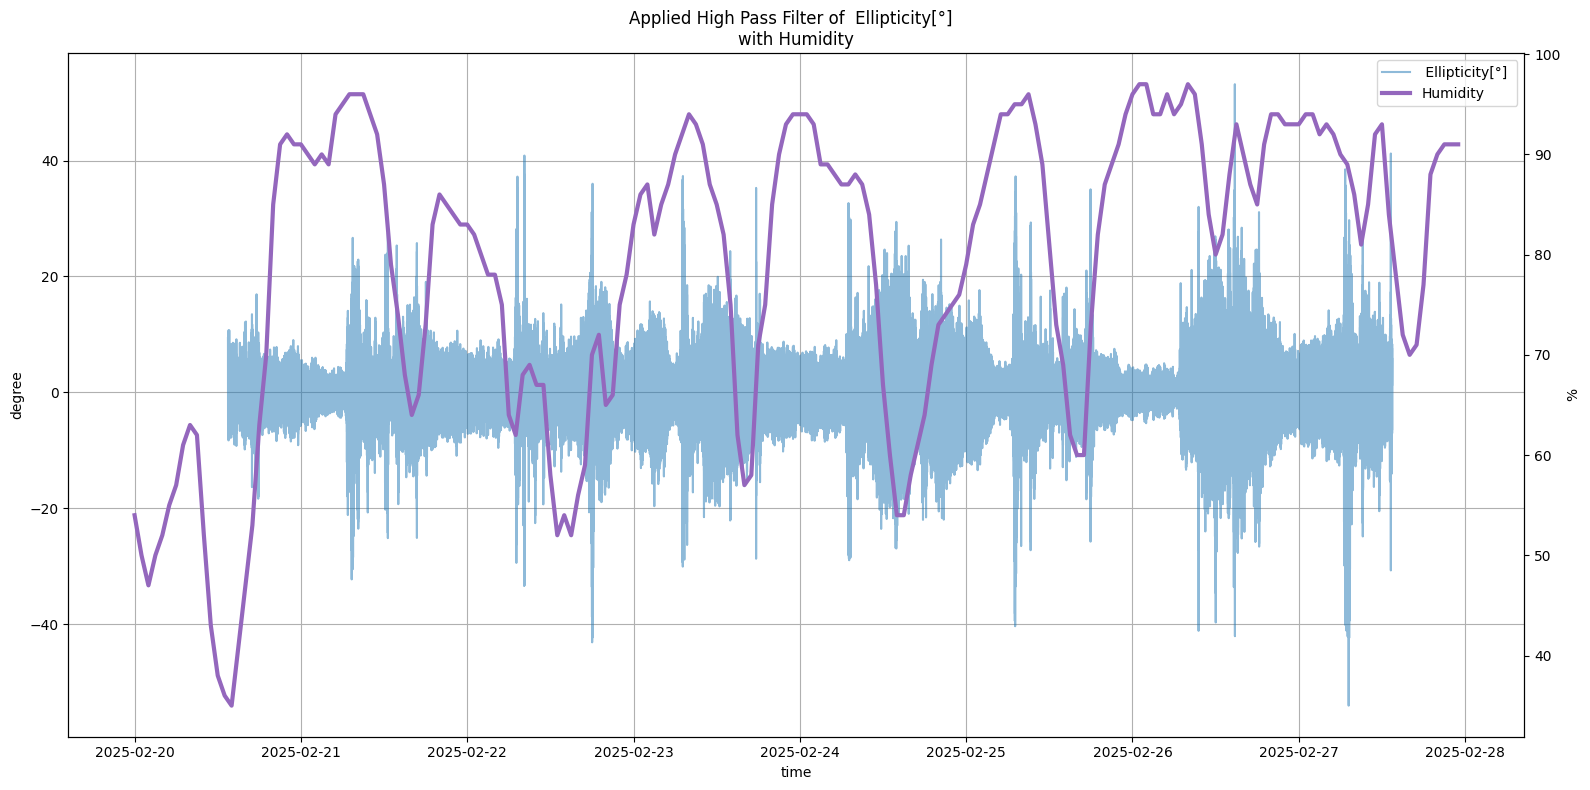

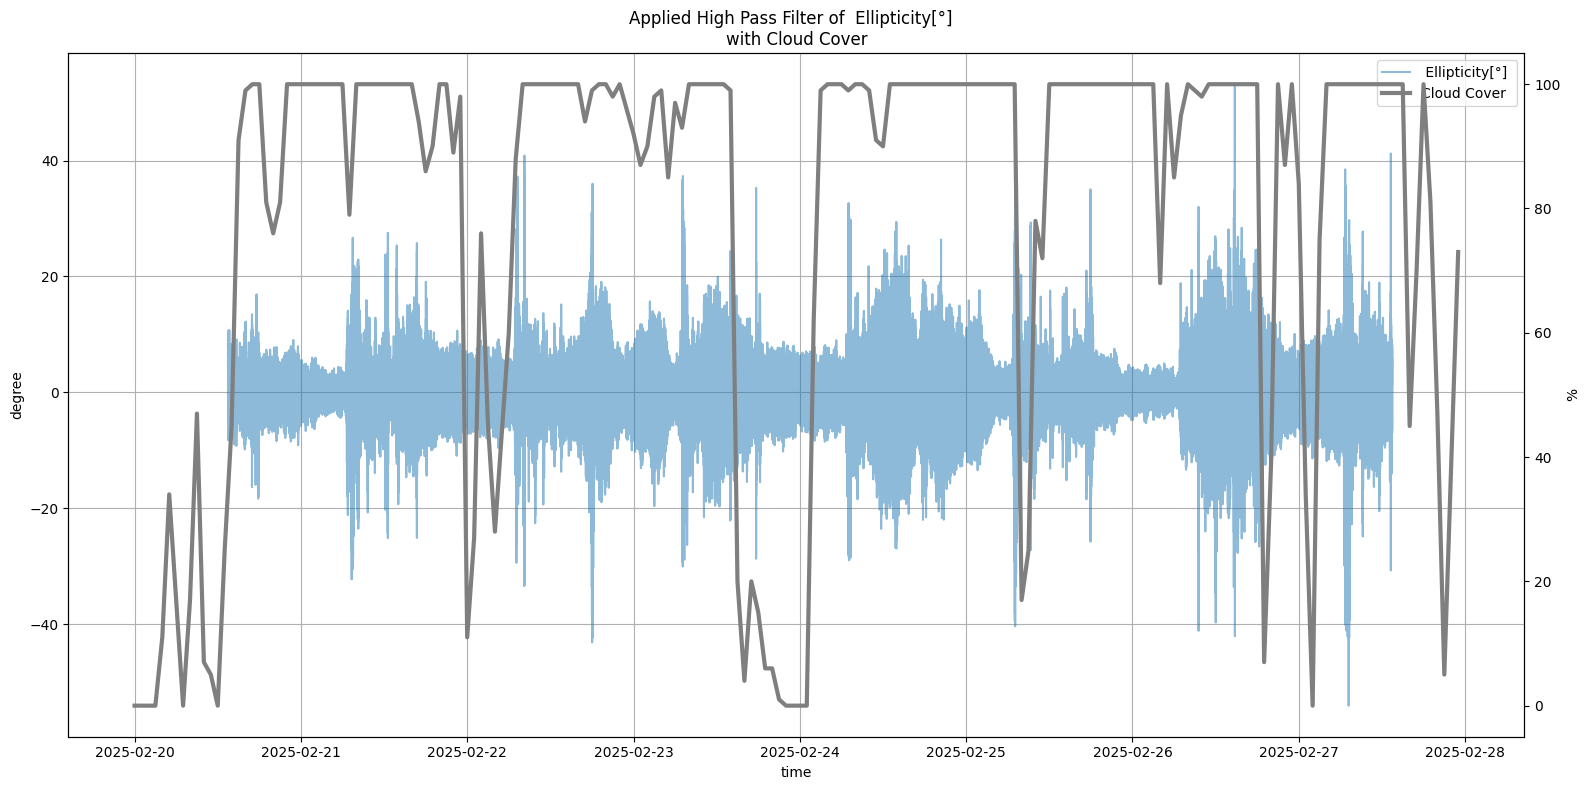

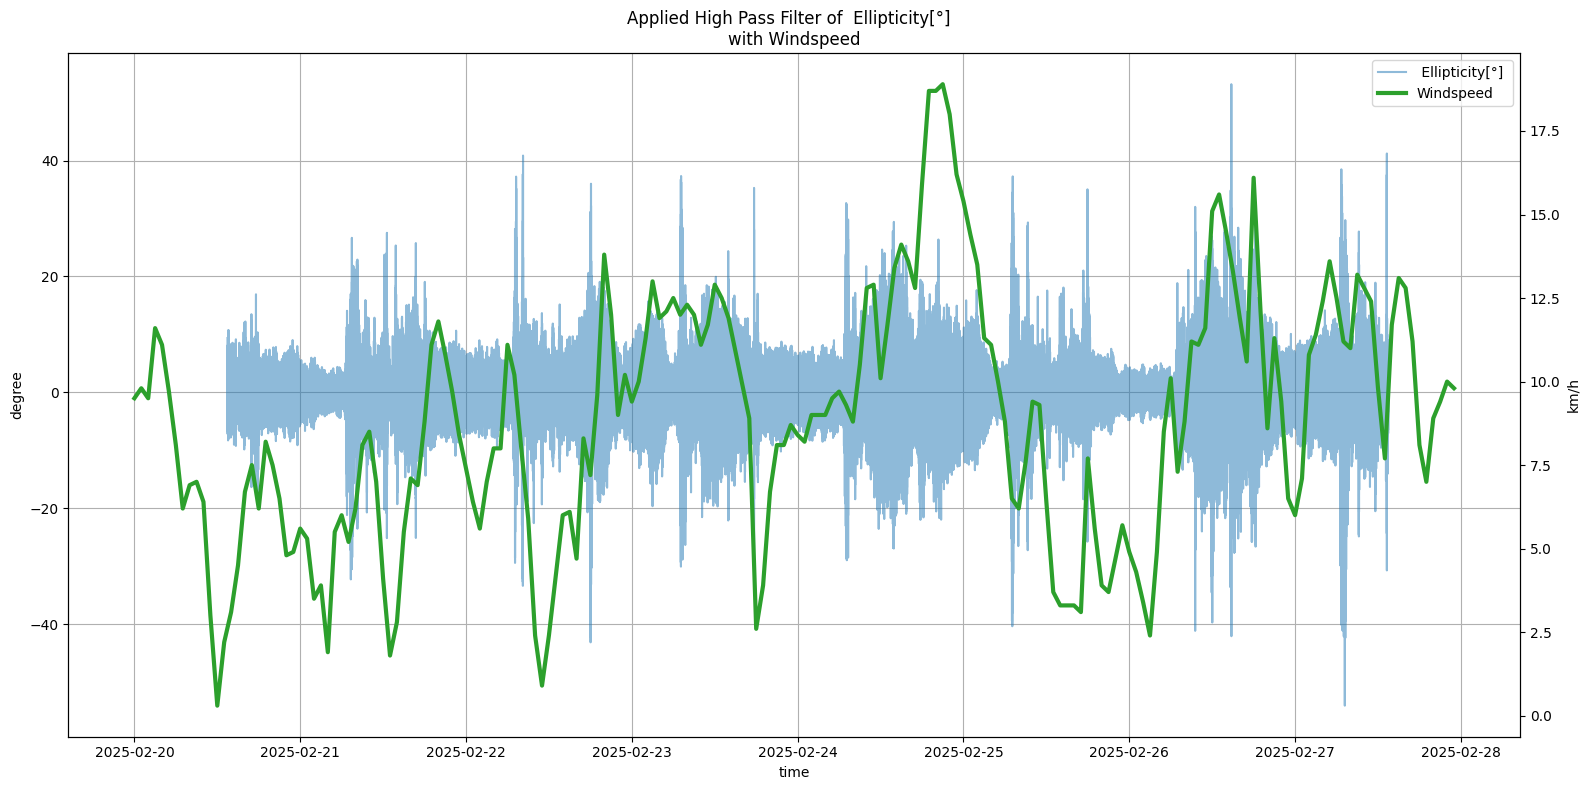

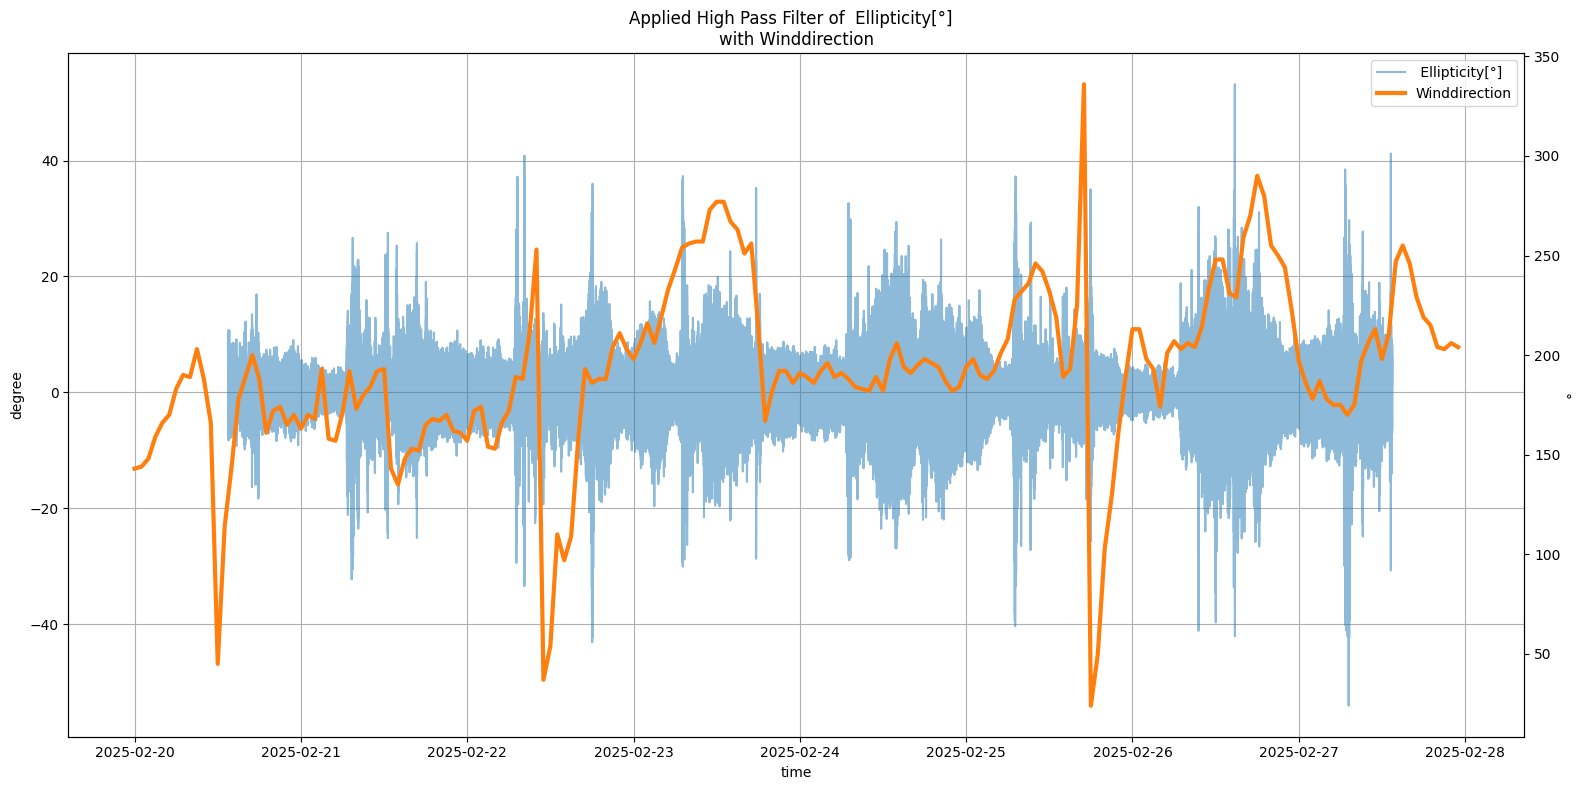

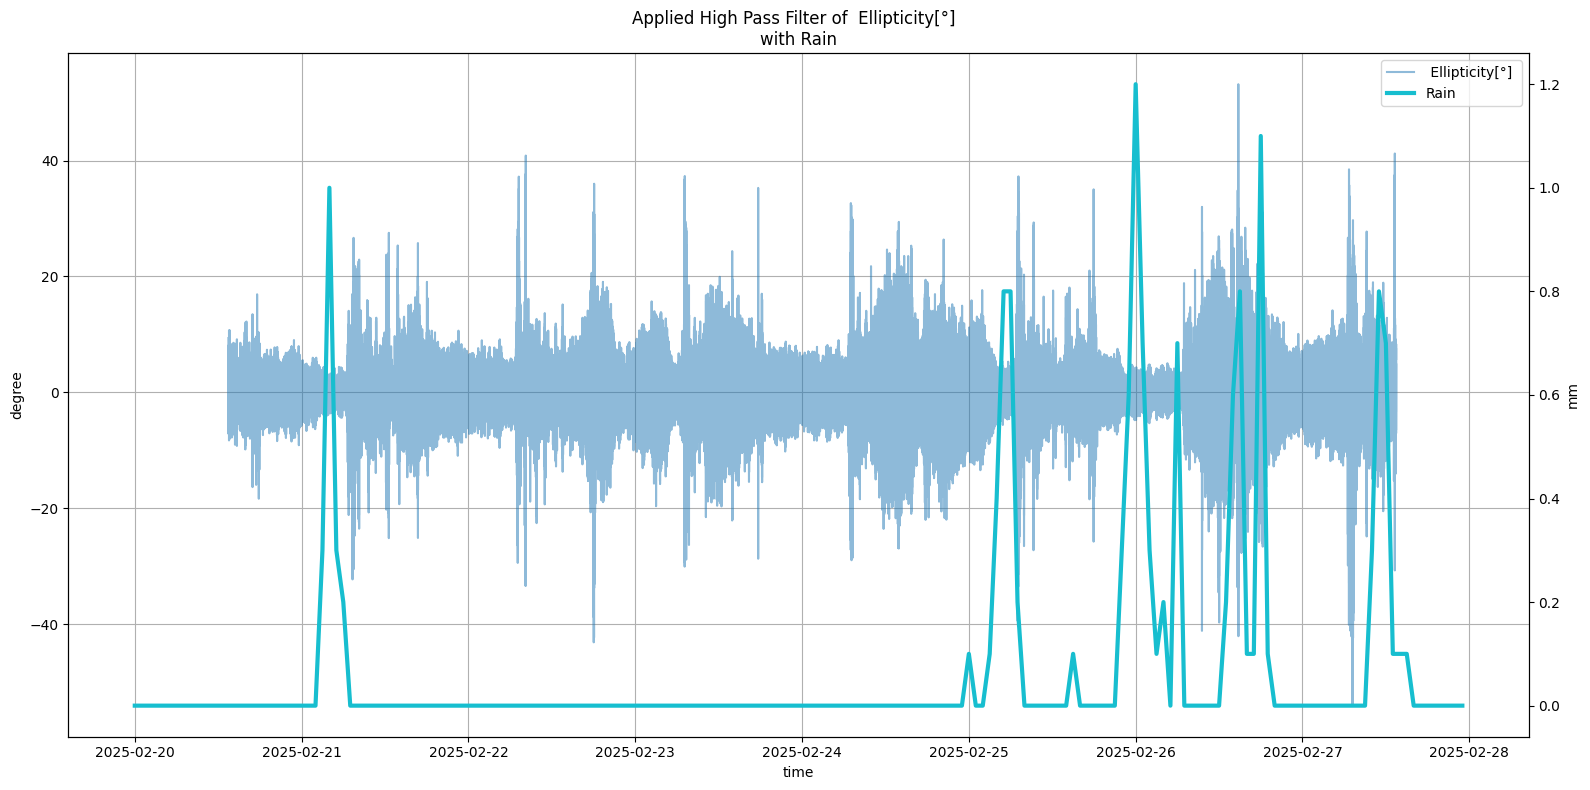

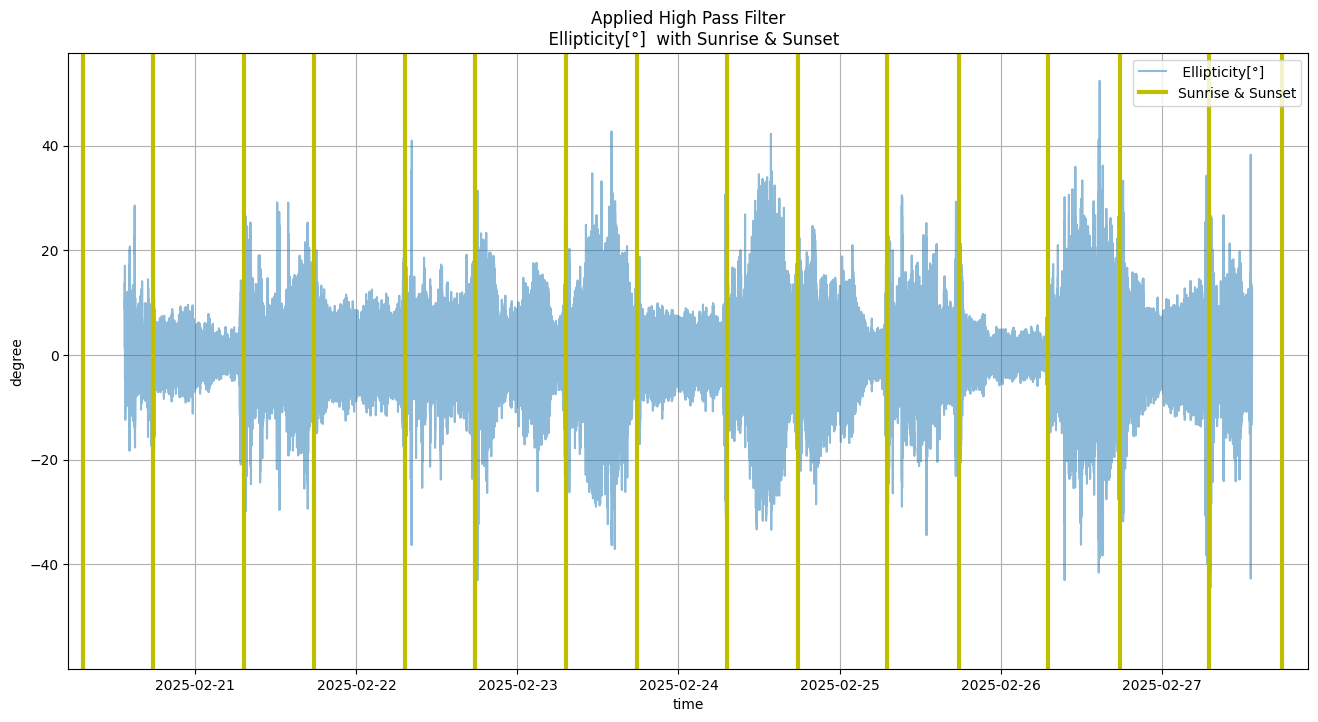

In [34]:
for current in range(len(w_data)):
    fig, ax1 = plt.subplots(figsize=(16, 8))

    ydata = np.array(angle[columns[10]])
    hps = highpass(ydata, 100)

    ax1.plot(angle.index, hps, label=columns[10], color= "tab:blue", alpha= 0.5)

    ax1.set_xlabel('time')
    ax1.set_ylabel('degree')
    h1, l1 = ax1.get_legend_handles_labels()

    ax2 = ax1.twinx()

    ax2.plot(weather.index, weather[w_data[current]["header"]], label=w_data[current]["label"], color = w_data[current]["color"], linewidth=3)
    ax2.set_ylabel(w_data[current]["unit"])
    h2, l2 = ax2.get_legend_handles_labels()

    ax1.grid()
    ax1.legend(h1+h2, l1+l2, loc="best")
    ax1.set_title(f'Applied High Pass Filter of {columns[10]} \nwith {w_data[current]["label"]}')

    plt.tight_layout()
    plt.show()

# Sunlight (day-night context)

plt.figure(figsize = (16,8))

ydata = np.array(angle[columns[10]])
hps = highpass(ydata, 1000)
plt.plot(angle.index, hps, label=columns[10], alpha= 0.5)

for i in range(len(sunrise)):
    plt.axvline(x = sunrise[i], color = 'y', linewidth=3)
    if i == 0: plt.axvline(x = sunset[i], color = 'y',label = 'Sunrise & Sunset', linewidth=3)
    else: plt.axvline(x = sunset[i], color = 'y', linewidth=3)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied High Pass Filter\n {columns[10]} with Sunrise & Sunset')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

### Spezielle Auffälligkeiten

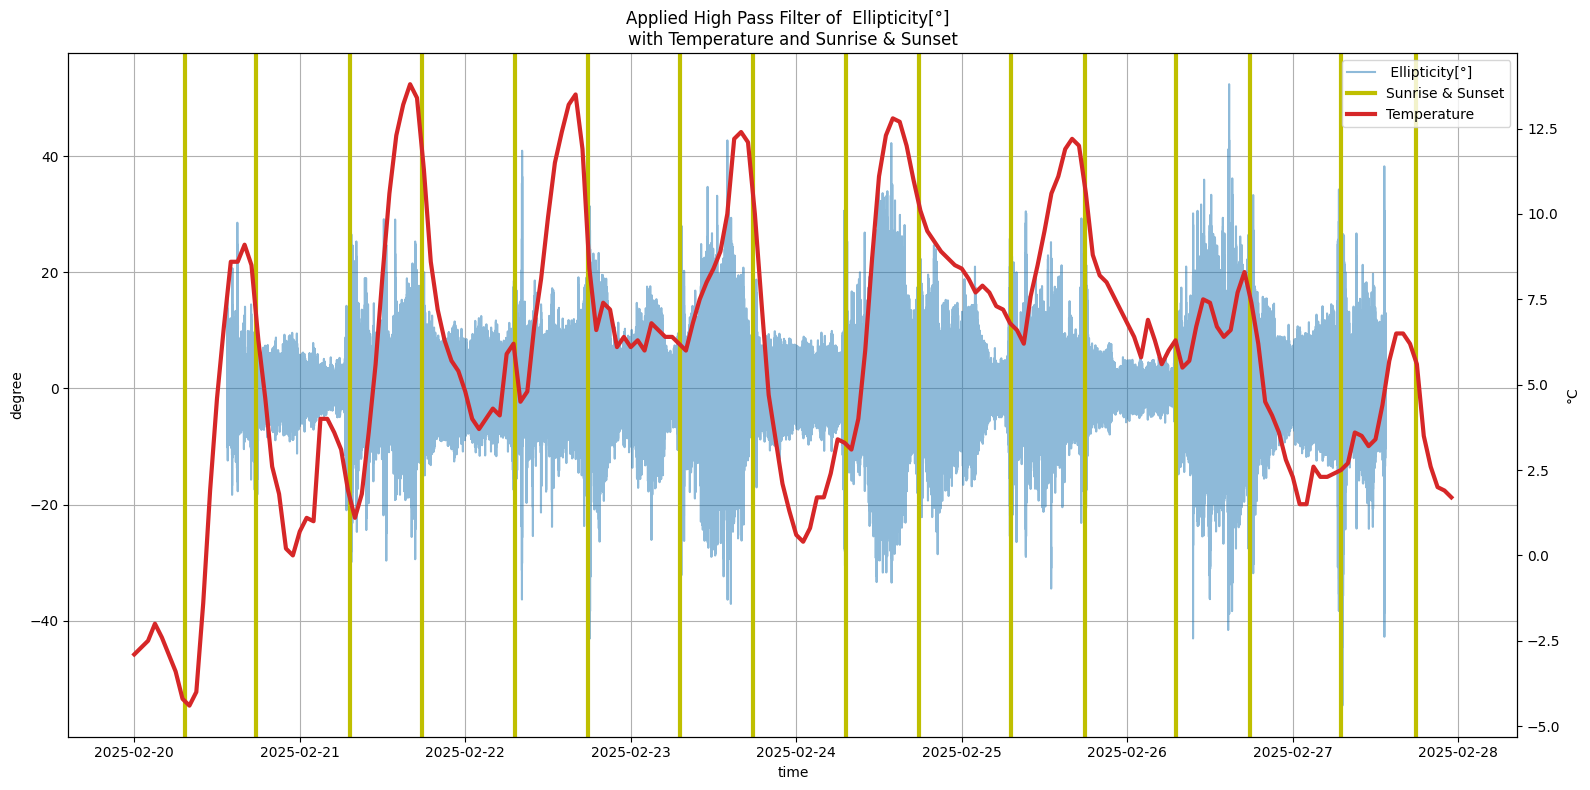

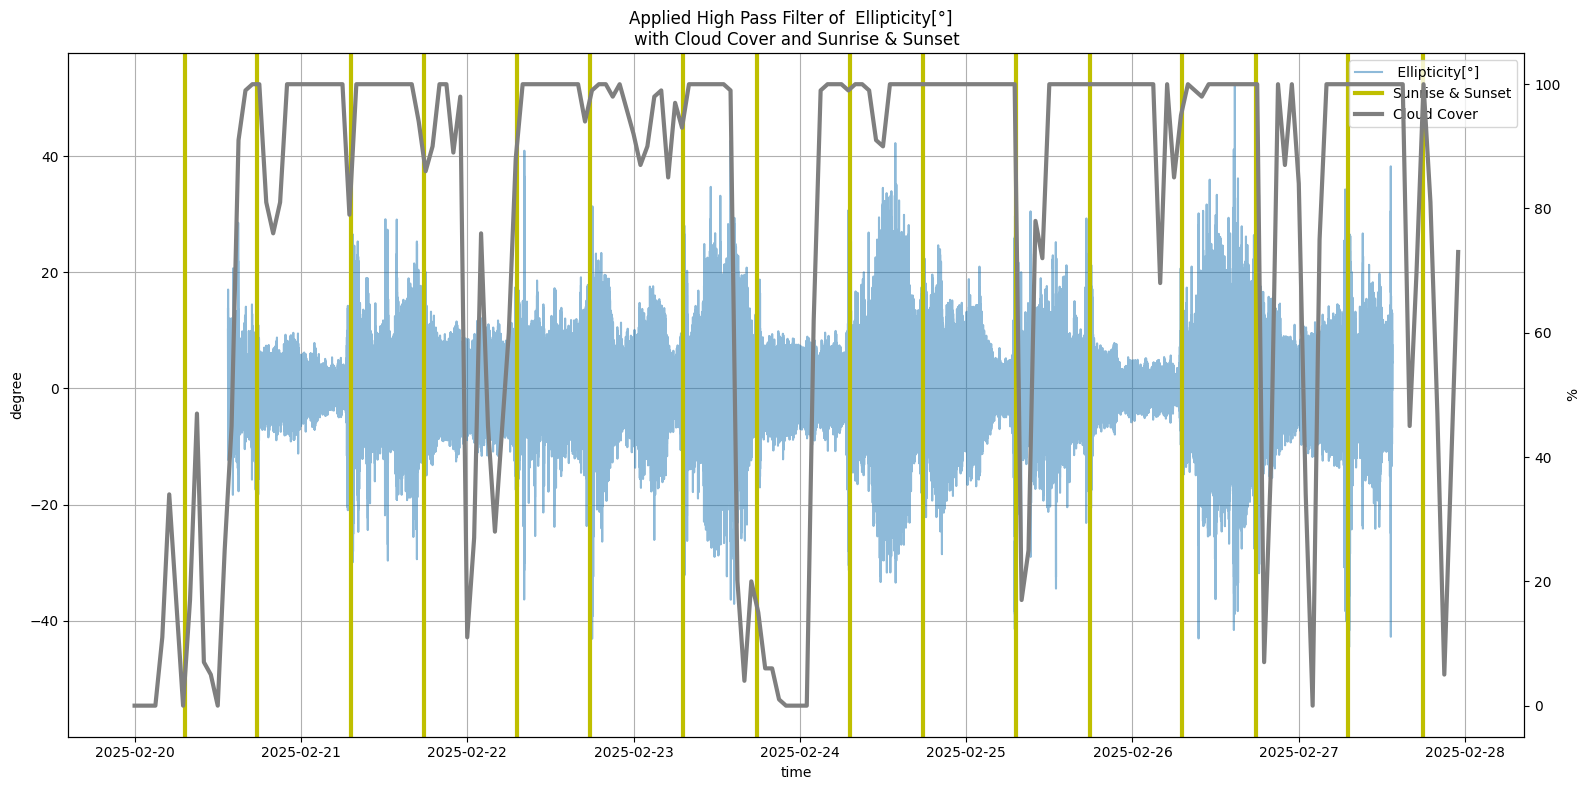

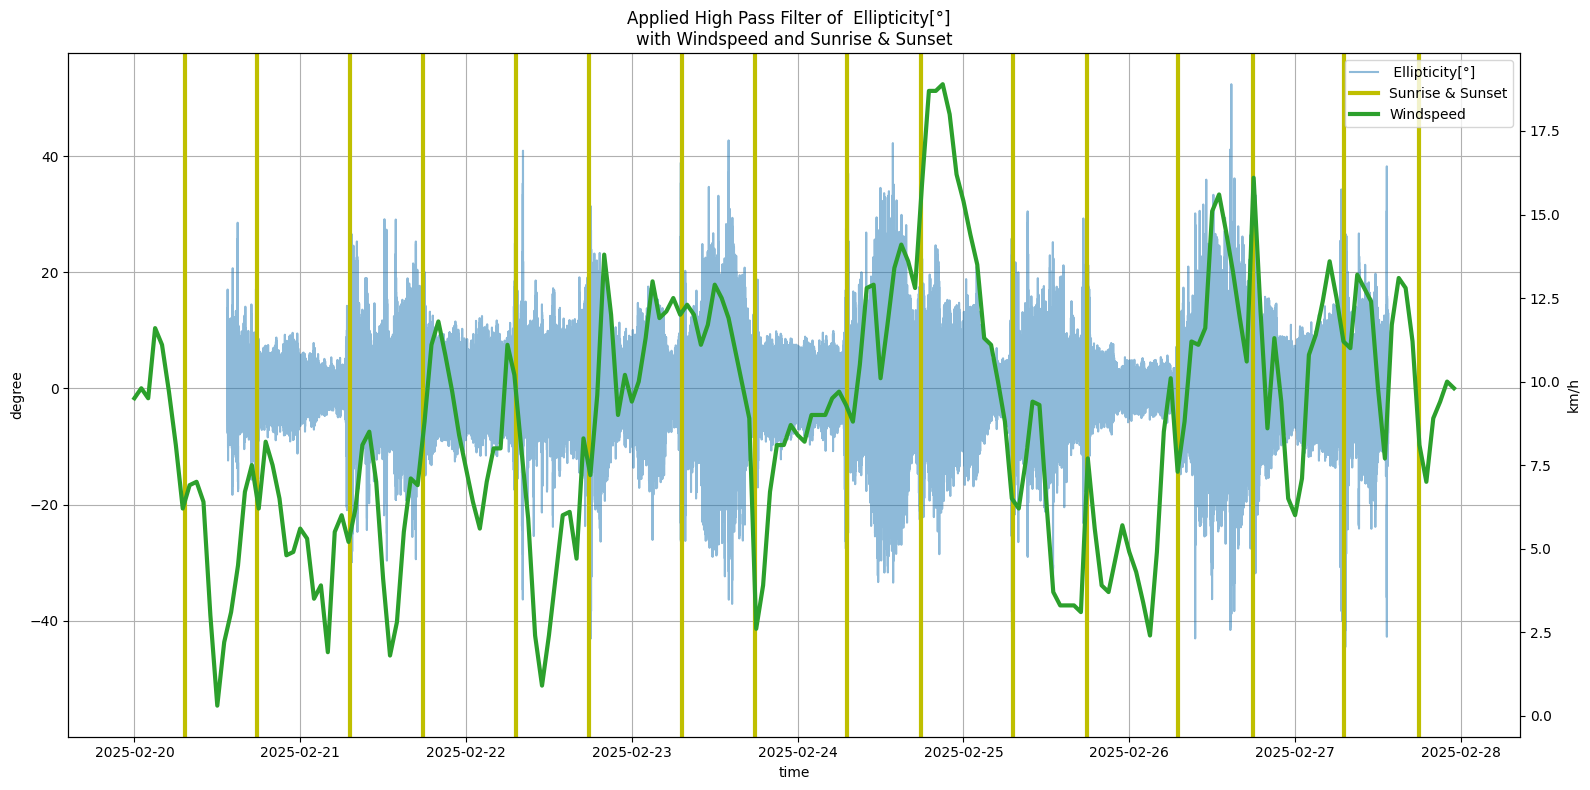

In [35]:
for current in [0,2,3]:
    fig, ax1 = plt.subplots(figsize=(16, 8))

    ydata = np.array(angle[columns[10]])
    hps = highpass(ydata, 1000)
    ax1.plot(angle.index, hps, label=columns[10], alpha= 0.5)

    for i in range(len(sunrise)):
        ax1.axvline(x = sunrise[i], color = 'y', linewidth=3)
        if i == 0: ax1.axvline(x = sunset[i], color = 'y',label = 'Sunrise & Sunset', linewidth=3)
        else: ax1.axvline(x = sunset[i], color = 'y', linewidth=3)

    ax1.set_xlabel('time')
    ax1.set_ylabel('degree')
    h1, l1 = ax1.get_legend_handles_labels()

    ax2 = ax1.twinx()

    ax2.plot(weather.index, weather[w_data[current]["header"]], label=w_data[current]["label"], color = w_data[current]["color"], linewidth=3)
    ax2.set_ylabel(w_data[current]["unit"])
    h2, l2 = ax2.get_legend_handles_labels()

    ax1.grid()
    ax1.legend(h1+h2, l1+l2, loc="best")
    ax1.set_title(f'Applied High Pass Filter of {columns[10]} \nwith {w_data[current]["label"]} and Sunrise & Sunset')

    plt.tight_layout()
    plt.show()